In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2

import numpy as np
import glob
import skimage
import skimage.io
import skimage.transform
from skimage.transform import rescale, resize, downscale_local_mean
from skimage.filters import gaussian
import matplotlib.pyplot as plt
import os
import sys
sys.path.append('./extraction_functions') #this is where we put all the functions.py
sys.path.append('./../../functions_PVA') #this is where we put all the functions.py
from save_load import *
from extract_triggers import *
import csv as csv
import itertools
from tqdm import tqdm

# sys.path.append('/home/samuele/anaconda3/envs/RFEst/lib/python3.9/site-packages')
#sys.path.append('/home/samuele/RFEst')


#UNCOMMENT WHEN USING THE BERENS METHOD
#from rfest import splineLG, splineLNP, splineLNLN
#from rfest.metrics import mse


from data import Dataset

from scipy.optimize import curve_fit

def corrcoef(x, y):
    """Return Pearson product-moment correlations coefficients.

    This is a wrapper around `np.corrcoef` to avoid:
        `RuntimeWarning: invalid value encountered in true_divide`.
    """

    assert len(x) > 0, len(x)
    assert len(y) > 0, len(y)
    assert len(x) == len(y), (len(x), len(y))

    is_x_deterministic = np.all(x == x[0])  # i.e. array filled with a unique value
    is_y_deterministic = np.all(y == y[0])  # i.e. array filled with a unique value
    if is_x_deterministic and is_y_deterministic:
        r = 1.0
    elif is_x_deterministic or is_y_deterministic:
        r = 0.0
    else:
        r = np.corrcoef(x, y)[0, 1]

    return r

Populating the interactive namespace from numpy and matplotlib


In [2]:
Selected_cells ={}
Count_cells={}
good_exps = [11,12,13,14,17,19]

Selected_cellsA = []
Selected_cellsB = []
Selected_cellsCp = []

#-----------------------------------------------------------------------------
# Experiment 11
selected_cellsA = [2 , 4 , 5 , 6 , 12 , 15 , 20 , 32 , 39 , 45 , 49 , 58 , 60 , 68 , 72 , 76 , 103 , 109 , 120 , 133 , 134 , 137 , 138 , 146 , 161 , 164 , 165 , 170 , 172 , 180 , 183 , 187 , 188 , 193 , 199 , 200 , 214 , 215 , 229 , 230 , 234 , 235 , 260 , 262 , 269 , 276 , 278 , 280 , 299 , 322 , 324 , 339 , 382 , 451 , 454 , 477 , 478 , 484 , 496 , 500 , 501 , 81 , 310 ]
selected_cellsB = [ 22 , 38 , 44 , 67 , 74 , 75 ,   85 , 95 , 105 , 107 , 111 , 142 ,  168 , 181 ,  207 ,  227 , 238 ,  248 , 252 , 259 , 263 , 275 , 286 ,  366 , 388 ,  491 , 504 , 514 , 517 , 518 , 467 ]
selected_cellsCp = [197,14,54,154,178,236,319,323,369,453,145,279,456,97,116,159,297,329,226,353,279,394,308,502]
# selected_cellsBm = [3,80,153,197,217,247,314,470]  #168,248,286,96,197,470
# selected_cellsC = [14 , 18 , 34 , 54 , 56 , 97 , 104 , 116 , 126 , 154 , 157 , 178 , 191 , 212 , 224 , 319 , 323 , 347 , 369 , 390 , 398 , 426 , 453 , 466 , 113 , 29 , 33 , 63 , 145 , 159 , 218 , 236 , 297 , 301 , 329 ]
# selected_cellsD = [24 , 42 , 46 , 64 , 66 , 93 , 122 , 125 , 144 , 149 , 167 , 185 , 205 , 223 , 226 , 233 , 245 , 249 , 254 , 279 , 285 , 296 , 308 , 313 , 338 , 341 , 353 , 356 , 372 , 394 , 435 , 456 , 502 ]

exp=11
Selected_cellsA.append(selected_cellsA)
Selected_cellsB.append(selected_cellsB)
Selected_cellsCp.append(selected_cellsCp)

Count_cells[exp]={}
Count_cells[exp]['class']=[len(selected_cellsA),len(selected_cellsB),len(selected_cellsCp)]
Count_cells[exp]['total']=np.sum([len(selected_cellsA),len(selected_cellsB),len(selected_cellsCp)])

# #-----------------------------------------------------------------------------
# Experiment 12
selected_cellsA = [3 , 10 , 11 , 19 , 24 , 29 , 33 , 44 , 48 , 58 , 61 , 63 , 70 , 72 , 73 , 75 , 76 , 82 , 83 , 86 , 87 , 93 , 109 , 116 , 120 , 124 , 130 , 132 , 140 , 142 , 146 , 150 , 158 , 171 , 175 , 178 , 179 , 182 , 184 , 188 , 191 , 192 , 200 , 205 , 211 , 227 , 234 , 235 , 240 , 245 , 263 , 264 , 287 , 297 , 298 , 335 , 354 , 372 , 380 , 395 , 415 , 441 , 529 , 588 , 595 , 597 , 600 , 629 , 648 ]
selected_cellsB = [488 , 37 , 46 , 51 , 65 , 68 , 74 , 88 , 95 , 111 , 125 , 128 , 133 , 152 , 161 , 168 , 173 , 185 , 189 ,  201 , 202 , 215 , 266 , 279 , 286 ,  364 , 399 , 419 , 450 , 459 , 460 , 466 , 478 , 494 , 496 , 514 , 539 , 543 , 570 , 576 , 577 , 637 , 665 , 271 , 657 ]
selected_cellsCp = [473,5,26,38,45,54,55,177,187,193,223,394,433,486,490,528,559,596,619,659,6,424]
selected_cellsC = [473 , 5 , 21 , 26 , 38 , 45 , 54 , 55 , 66 , 104 , 147 , 156 , 177 , 187 , 193 , 212  , 223 , 290 , 304 , 329 , 367 , 378 , 394 , 433 , 471 , 486 , 490 , 528 , 559 , 596 , 619 , 659 , 667 , 6 , 424 ]
selected_cellsD = [13 , 139 , 190 , 207 , 213 , 219 , 226 , 288 , 308 , 353 ,196,338]

exp=12
Selected_cellsA.append(selected_cellsA)
Selected_cellsB.append(selected_cellsB)
Selected_cellsCp.append(selected_cellsCp)

Count_cells[exp]={}
Count_cells[exp]['class']=[len(selected_cellsA),len(selected_cellsB),len(selected_cellsCp)]
Count_cells[exp]['total']=np.sum([len(selected_cellsA),len(selected_cellsB),len(selected_cellsCp)])

#-----------------------------------------------------------------------------
# Experiment 13
selected_cellsA = [0 , 56 , 65 , 77 , 91 , 92 , 96 , 112 , 130 , 144 , 158 , 165 , 166 , 170 , 184 , 187 , 193 , 209 , 234 , 261 , 265 , 382 , 386 , 394 , 450 , 487 , 490 , 501 , 205 ]
selected_cellsAm = [2 , 3 , 16 , 28 , 67 , 71 , 99 , 101 , 108 , 111 , 128 , 139 , 140 , 153 , 177 , 180 , 186 , 200 , 202 , 208 , 220 , 225 , 228 , 252 , 257 , 259 , 387 , 528 ,  634 , 684 , 702 , 706 , 717 , 748 ]
selected_cellsB = [18 , 24 , 32 , 41 ,  54 , 60 , 64 , 66 , 69 , 72 , 102 , 103 , 132 , 134 , 148 , 149 , 150 ,
                   159 , 167 , 174 , 178 , 185 , 190 , 194 , 197 , 207 , 239 ,  269 , 270 ,  600 , 606 , 697 ,
                   703 , 704 , 720 ,  744 , 749 ]
selected_cellsCp = [51,738,87,40,42,47,74,76,87,90,113,120,129,142,155,217,262,268,377,650,741]
# selected_cellsC = [621 ,51,154,240,267,505,654,698,738,87 , 38 , 39 , 40 , 42 , 47 , 55 , 58 , 62 , 74 , 76 , 78 , 80 , 87 , 90 , 95 , 113 , 120 , 125 , 127 , 129 , 142 , 143 , 155 , 176 , 199 , 211 , 214 , 217 , 254 , 256 , 258 , 262 , 268 , 377 , 629 , 642 , 650 , 699 , 741  ]
# selected_cellsD = [1 , 6 , 26 , 43 , 44 , 145 , 175 , 223 , 233 , 527 ]

exp=13
Selected_cellsA.append(selected_cellsA+selected_cellsAm)
Selected_cellsB.append(selected_cellsB)
Selected_cellsCp.append(selected_cellsCp)

Count_cells[exp]={}
Count_cells[exp]['class']=[len(selected_cellsA)+len(selected_cellsAm),len(selected_cellsB),len(selected_cellsCp)]
Count_cells[exp]['total']=np.sum([len(selected_cellsA)+len(selected_cellsAm),len(selected_cellsB),len(selected_cellsCp)])

#-----------------------------------------------------------------------------
# Experiment 14
selected_cellsA = [0 , 14 , 35 , 44 , 60 , 83 , 95 , 132 , 149 , 150 , 158 , 167 , 201 , 202 , 216 , 225 , 227 , 234 , 239 , 241 , 256 , 269 , 271 , 291 , 302 , 303 , 307 , 310 , 329 , 334 , 339 , 341 , 348 , 351 , 357 , 378 , 381 , 419 , 420 , 421 , 424 , 429 , 432 , 448 , 461 , 482 , 490 , 521 , 522 , 554 , 575 , 601 , 627 , 666 , 667 , 672 , 678 , 714 , 715 , 722 , 723 , 724 ]
selected_cellsAm = [6 , 17 , 18 , 46 , 54 , 56 , 58 , 63 , 92 , 96 , 110 , 113 , 122 , 133 , 153 , 157 , 197 , 200 , 209 , 224 , 236 , 246 , 251 , 277 , 283 , 337 , 372 , 423 , 425 , 426 , 477 , 523 , 542 , 544 , 557 , 593 , 632 , 637 , 701 , 703 , 720 , 728 ]
selected_cellsBp = [11,13,16,28,49,72,124,129,137,151,163,164,170,175,193,233,237,253,266,267,295,297,299,319,322,356,360,366,411,433,480,628,696,706,718,719,727]
# selected_cellsB = [ grille couts cdd sorbonne10 , 11 , 13 , 16 , 19 , 28 , 43 , 49 , 72 , 117 , 124 , 129 , 134 , 137 , 151 , 163 , 164 , 170 , 175 , 176 , 192 , 193 , 195 , 233 , 235 , 237 , 252 , 253 , 265 , 266 , 267 , 270 , 287 , 295 , 297 , 299 , 308 , 319 , 322 , 328 , 356 , 360 , 366 , 368 , 398 , 411 , 433 , 480 , 481 , 519 , 541 , 570 , 616 , 628 , 665 , 696 , 706 , 718 , 719 , 727 ]
# selected_cellsC = [ 1 , 36 , 41 , 47 , 84 , 86 , 91 , 94 , 112 , 125 , 139 , 165 , 173 , 179 , 219 , 232 , 274 , 301 , 316 , 317 , 342 , 344 , 345 , 350 , 358 , 363 , 467 , 497 , 537 ]

exp=14
Selected_cellsA.append(selected_cellsA)
Selected_cellsB.append(selected_cellsAm)
Selected_cellsCp.append(selected_cellsBp)

Count_cells[exp]={}
Count_cells[exp]['class']=[len(selected_cellsA),len(selected_cellsAm),len(selected_cellsBp)]
Count_cells[exp]['total']=np.sum([len(selected_cellsA),len(selected_cellsAm),len(selected_cellsBp)])

#------------------------------------------------------------------------------
# Experiment 17
selected_cellsA = [4 , 18 , 19 , 53 , 78 , 83 , 88 , 89 , 98 , 113 , 117 , 123 , 127 , 130 , 141 , 145 , 164 , 178 , 191 , 194 , 195 , 197 , 200 , 209 , 210 , 216 , 239 , 262 , 268 , 270 , 289 , 290 , 312 , 350 , 418 , 499 , 500 , 508 , 541 , 567 , 639 , 641 , 642 , 737 , 754 , 776 , 791 , 792 , 794 , 813 , 815 , 823 , 868 , 901 , 924 , 939 , 972 , 992 , 996 , 1007 , 1023 , 1029 , 1030 , 1032 , 1033 , 1036 ]
selected_cellsB = [22 , 30 , 116 , 177 , 260 , 285 , 339 , 349 , 364 , 376 , 402 , 412 , 436 , 459 , 515 , 532 , 534 , 553 , 561 , 579 , 680 , 706 , 708 , 743 , 753 , 767 , 796 , 800 , 843 , 862 , 872 , 874 , 892 , 905 , 910 , 942 , 956 , 960 , 962 , 991 , 994 , 998 , 1004 , 1009 , 1011 , 1014 , 1021 , 1026 , 1031 ]
selected_cellsCp = [13,136,172,182,273,300,543,608,632,759,774,806,880,916,931,954,969,975,763,898,950,973]
# selected_cellsBm = [622 , 688 , 763 , 898 , 950 , 973 , 990 , 1019 ]
# selected_cellsC = [13 , 136 , 172 , 182 , 233 , 273 , 300 , 543 , 575 , 608 , 632 , 668 , 672 , 696 , 759 , 774 , 780 , 806 , 810 , 812 , 876 , 880 , 916 , 927 , 931 , 954 , 967 , 969 , 975 , 979 , 1002 ]
# selected_cellsD = [57 , 264 , 388 , 428 , 450 , 467 , 480 , 566 , 596 , 606 , 636 , 698 , 720 , 739 , 782 , 884 , 886 , 923 ]

exp=17
Selected_cellsA.append(selected_cellsA)
Selected_cellsB.append(selected_cellsB)
Selected_cellsCp.append(selected_cellsCp)

Count_cells[exp]={}
Count_cells[exp]['class']=[len(selected_cellsA),len(selected_cellsB),len(selected_cellsCp)]
Count_cells[exp]['total']=np.sum([len(selected_cellsA),len(selected_cellsB),len(selected_cellsCp)])

#------------------------------------------------------------------------------
# Experiment 19
selected_cellsA = [2 , 5 , 25 , 26 , 36 , 43 , 46 , 50 , 52 , 56 , 62 , 79 , 94 , 106 , 109 , 114 , 122 , 128 , 129 , 137 , 138 , 142 , 153 , 160 , 162 , 175 , 182 , 184 , 190 , 196 , 198 , 200 , 204 , 211 , 212 , 216 , 220 , 223 , 225 , 236 , 237 , 248 , 251 , 252 , 254 , 269 , 271 , 274 , 282 , 284 , 286 , 297 , 305 , 310 , 323 , 347 , 356 , 360 , 369 , 377 , 416 , 427 , 469 , 486 , 499 , 501 , 502 ]
selected_cellsAm = [21 , 30 , 45 , 47 , 61 , 67 , 89 , 96 , 118 , 123 , 125 , 143 , 157 , 159 , 165 , 171 , 174 , 185 , 203 , 213 , 257 , 262 , 279 , 311 , 338 , 340 , 349 , 353 , 359 , 366 , 386 , 411 , 415 , 425 , 449 , 467 , 468 , 487 , 593 , 598 ]
selected_cellsBp = [84,97,1,10,16,23,28,33,35,39,44,65,82,83,102,107,130,193,206,219,253,285,293,300,318,319,322,329,330,336,342,385,390,435,436,443,493,498,570]
# selected_cellsB = [1 , 6 , 10 , 16 , 23 , 28 , 33 , 35 , 39 , 44 , 65 , 68 , 82 , 83 , 102 , 107 , 130 , 134 , 145 , 146 , 156 , 173 , 193 , 201 , 206 , 219 , 234 , 253 , 272 , 285 , 289 , 293 , 296 , 299 , 300 , 318 , 319 , 322 , 329 , 330 , 336 , 342 , 385 , 390 , 408 , 432 , 435 , 436 , 443 , 492 , 493 , 498 , 570 , 597 , 603 , 604 ]
# selected_cellsC = [0 , 11 , 15 , 24 , 57 , 75 , 80 , 81 , 84 , 97 , 101 , 108 , 121 , 140 , 164 , 168 , 191 , 202 , 229 , 232 , 259 , 263 , 270 , 277 , 281 , 287 , 307 , 325 , 337 , 341 , 373 , 422 , 528 , 555 , 560 , 565 ]

exp=19
Selected_cellsA.append(selected_cellsA)
Selected_cellsB.append(selected_cellsAm)
Selected_cellsCp.append(selected_cellsBp)

Count_cells[exp]={}
Count_cells[exp]['class']=[len(selected_cellsA),len(selected_cellsAm),len(selected_cellsBp)]
Count_cells[exp]['total']=np.sum([len(selected_cellsA),len(selected_cellsAm),len(selected_cellsBp)])


#################################################################################33
i=0
for exp in good_exps:
    Selected_cells[exp]=[Selected_cellsA[i],Selected_cellsB[i],Selected_cellsCp[i]]
    i+=1

In [3]:
Count_cells

{11: {'class': [63, 31, 24], 'total': 118},
 12: {'class': [69, 45, 22], 'total': 136},
 13: {'class': [63, 37, 21], 'total': 121},
 14: {'class': [62, 42, 37], 'total': 141},
 17: {'class': [66, 49, 22], 'total': 137},
 19: {'class': [67, 40, 39], 'total': 146}}

In [3]:
np.sort(np.array(Selected_cells[17][0]+Selected_cells[17][1]))

array([   4,   18,   19,   22,   30,   53,   78,   83,   88,   89,   98,
        113,  116,  117,  123,  127,  130,  141,  145,  164,  177,  178,
        191,  194,  195,  197,  200,  209,  210,  216,  239,  260,  262,
        268,  270,  285,  289,  290,  312,  339,  349,  350,  364,  376,
        402,  412,  418,  436,  459,  499,  500,  508,  515,  532,  534,
        541,  553,  561,  567,  579,  639,  641,  642,  680,  706,  708,
        737,  743,  753,  754,  767,  776,  791,  792,  794,  796,  800,
        813,  815,  823,  843,  862,  868,  872,  874,  892,  901,  905,
        910,  924,  939,  942,  956,  960,  962,  972,  991,  992,  994,
        996,  998, 1004, 1007, 1009, 1011, 1014, 1021, 1023, 1026, 1029,
       1030, 1031, 1032, 1033, 1036])

In [4]:
exp=11
np.sort(np.array(Selected_cells[exp][0]+Selected_cells[exp][1])).shape

(94,)

# Cell for counting the As, Bs and Cs and knowing their number

In [6]:
exp=14  #choose the experiment

if exp==11: grades_folder='/media/samuele/Samuele_01/Exp_11/sorting/recording_0/recording_0.GUI/'
if exp==12: grades_folder='/media/samuele/Samuele_01/Exp_12/sorting/exp12-meas_01/exp12-meas_01-merged.GUI/'
if exp==13: grades_folder='/media/samuele/Samuele_01/Exp_13/sorting/'
if exp==14: grades_folder='/media/samuele/Samuele_01/Exp_14/sorting/'
if exp==17: grades_folder='/media/samuele/Samuele_01/Exp_17/sorting/exp17-meas_01/exp17-meas_01.GUI/'
if exp==19: grades_folder='/media/samuele/Samuele_01/Exp_19/sorting/'
#in salamander experiments all the cells used were As

stim_trials_f= open(grades_folder + 'exp{0}-cluster_quality.csv'.format(exp))
stim_trials_f = csv.reader(stim_trials_f,delimiter=",")
stim_trials=[]

As=[]
Bs=[]
Cs=[]
Ds=[]
for row in stim_trials_f: 
    if exp==11 or exp==17: stim_trials.append(np.array(row[0].split(',')))
    else: stim_trials.append(np.array(row))
stim_trials = np.array(stim_trials[1:])
#print(stim_trials)
                            
for row in stim_trials:
    #print(row)
    if row[1]=='A' or row[1]=='A-': As.append(int(row[0]))
    elif row[1]=='B' or row[1]=='B+': Bs.append(int(row[0]))
    elif row[1]=='B-' or row[1]=='C' or row[1]=='C+': Cs.append(int(row[0]))
    else: Ds.append(int(row[0]))
        
print('Exp{0}: As:{1} Bs:{2} Cs:{3} Ds:{4}'.format(exp,len(As),len(Bs),len(Cs),len(Ds)))                           

Exp14: As:104 Bs:60 Cs:29 Ds:16


## An authomatic way of knowing if for a cell there are experimental LSTAs and polarity invertions or not

### here for each experiment, the Berens denoising method is run and the outputs for all the images of all the cells are stored

In [36]:
#Experimental LSTAs determination method through the Berens

#this cell calculates and saves the denoised lstas that the berens gives

#IT TAKES VERY LONG TO RUN, SO RUN IT ONLY IF YOU DON'T HAVE THE BERENS OUTPUT SAVED ALREADY!!!!!

exp=19
s600=False

Skip=False
LAP4=True

if exp<14:
    if s600:
        pert_nb=600
        img_nb=12
    else:
        pert_nb=1200
        img_nb=7
if exp==17 or exp==14 or exp==19:
    pert_nb=1000
    img_nb=8
if exp==101 or exp==102:
    pert_nb=1200
    img_nb=4

if exp<14:
    if s600:
        resp=np.load('/media/samuele/Samuele_01/Exp_{0}/analysis/Response_shaped_for_Berens_exp{0}_s600.npy'.format(exp))
        stim=np.load('/media/samuele/Samuele_01/Exp_{0}/analysis/Stimulus_shaped_for_Berens_exp{0}_s600.npy'.format(exp))
    else:
        resp=np.load('/media/samuele/Samuele_01/Exp_{0}/analysis/Response_shaped_for_Berens_exp{0}_s1200.npy'.format(exp))
        stim=np.load('/media/samuele/Samuele_01/Exp_{0}/analysis/Stimulus_shaped_for_Berens_exp{0}_s1200.npy'.format(exp))
elif exp>=14 and exp<100:
    if LAP4: resp=np.load('/media/samuele/Samuele_01/Exp_{0}/analysis/Response_shaped_for_Berens_exp{0}_s1000_LAP4.npy'.format(exp))
    else: resp=np.load('/media/samuele/Samuele_01/Exp_{0}/analysis/Response_shaped_for_Berens_exp{0}.npy'.format(exp))
    stim=np.load('/media/samuele/Samuele_01/Exp_{0}/analysis/Stimulus_shaped_for_Berens_exp{0}.npy'.format(exp))

else:
    resp=np.load('/media/samuele/Samuele_01/Salamander{0}/Response_shaped_for_Berens_exp{1}.npy'.format(exp-100,exp))
    stim=np.load('/media/samuele/Samuele_01/Salamander{0}/Stimulus_shaped_for_Berens_exp{1}.npy'.format(exp-100,exp))
    
cell=30
if Skip: range_=[cell]
else:
    if exp==101:range_=np.array([815,816,817,821,823,842,850,857,865,868,869,871,883,886,887,888,889,892,894,903,905,907,913,914,915,916,917])
    elif exp==102:range_=np.array([1154,1165,1167,1178,1181,1182,1183,1184,1185,1186,197,999,1000,1009,1014,1018,1029,1042,1046,1047,1051,1055,109])
    else:range_=np.sort(np.array(Selected_cells[exp][0]+Selected_cells[exp][1]))
    
if exp==11:
    if s600: pckls_folder='/media/samuele/Samuele_01/Exp_11/analysis/s600/'
    else:pckls_folder='/media/samuele/Samuele_01/Exp_11/analysis/s1200_rasters/'
if exp==12:
    if s600: pckls_folder='/media/samuele/Samuele_01/Exp_12/analysis/s600/'
    else:pckls_folder='/media/samuele/Samuele_01/Exp_12/analysis/s1200_rasters_newcode/'
if exp==13:pckls_folder='/media/samuele/Samuele_01/Exp_13/analysis/Sam_analysis_trial/s1200_rasters_new/'
if exp==14:
    if LAP4: pckls_folder='/media/samuele/Samuele_01/Exp_14/analysis/s1000_lap4/'
    else: pckls_folder='/media/samuele/Samuele_01/Exp_14/analysis/s1000/'
if exp==17:
    if LAP4: pckls_folder='/media/samuele/Samuele_01/Exp_17/analysis/s1000_lap4/'
    else: pckls_folder='/media/samuele/Samuele_01/Exp_17/analysis/s1000/'
if exp==19:
    if LAP4: pckls_folder='/media/samuele/Samuele_01/Exp_19/analysis/s1000_lap4/'
    else: pckls_folder='/media/samuele/Samuele_01/Exp_19/analysis/s1000/'

totcell_nb=0
cell_names=[]
for filename in os.listdir(pckls_folder):
    if filename.endswith(".pkl"):
        cell_names.append(int(filename.split('_')[2][1:] ) )
        totcell_nb+=1
cell_names=np.array(cell_names)

berens_LSTAS=np.zeros((len(range_),img_nb,108,108))
exp_LSTAs_pol_ber=[]
for cell_nb,cell in enumerate(tqdm(range_)):
    response=resp[np.where(cell_names.argsort()==np.where(cell_names==cell)[0][0])[0][0]]
    polarities=np.zeros((img_nb))
    for nb,resp_to_image in enumerate(response):
        stimulus=stim[nb]
        size=72
        dims =(size,size)
        df = [24, 24] #[20,12] 
        lag=0
        try: 
            lg = splineLG((stimulus/stimulus.max()).reshape(pert_nb, size*size), resp_to_image, dims=dims, dt=lag, df=df)
            lg.fit(metric='corrcoef',
                              num_iters=1000, verbose=0, tolerance=10,
                              beta=0.010)
            res_ber=resize(lg.w_opt.reshape((size,size)), (108, 108), anti_aliasing=True)
        except: res_ber=np.zeros((108,108))
        if res_ber.max()>abs(res_ber.min()):
            if res_ber.max()-7*res_ber.std()>0: polarities[nb]=1
            else: polarities[nb]=0
        else:
            if res_ber.min()+7*res_ber.std()<0: polarities[nb]=-1
            else: polarities[nb]=0
        berens_LSTAS[cell_nb, nb]= res_ber
    exp_LSTAs_pol_ber.append((cell,polarities))
#         plt.figure()
#         plt.imshow(res_ber)
#         print(res_ber.std(), res_ber.max(), res_ber.min())
exp_LSTAs_pol_ber=np.array(exp_LSTAs_pol_ber, dtype=object)
#np.save('/media/eqs8/Samuele_01/Exp_{0}/analysis/exp_LSTAS_labels_berens_exp{0}'.format(exp),exp_LSTAs_pol_ber)
if exp<14:
    if s600==True:
        np.save('/media/samuele/Samuele_01/Exp_{0}/analysis/Best_denoised_LSTAS_berens_exp{0}_s600'.format(exp),berens_LSTAS)
    else:
        np.save('/media/samuele/Samuele_01/Exp_{0}/analysis/Best_denoised_LSTAS_berens_exp{0}_s1200'.format(exp),berens_LSTAS)
    
elif exp>100:np.save('/media/samuele/Samuele_01/Salamander{0}/Best_denoised_LSTAS_berens_exp{1}'.format(exp-100,exp),berens_LSTAS)
else: 
    if LAP4: np.save('/media/samuele/Samuele_01/Exp_{0}/analysis/Best_denoised_LAP4_LSTAS_berens_exp{0}'.format(exp),berens_LSTAS)
    else: np.save('/media/samuele/Samuele_01/Exp_{0}/analysis/Best_denoised_LSTAS_berens_exp{0}'.format(exp),berens_LSTAS)

  0%|                                                   | 0/107 [00:00<?, ?it/s]

Total time elapsed: 5.490 s.
Total time elapsed: 5.481 s.
Total time elapsed: 5.502 s.
Total time elapsed: 6.048 s.
Total time elapsed: 6.295 s.
Total time elapsed: 6.213 s.
Total time elapsed: 6.273 s.
Total time elapsed: 6.398 s.


  1%|▍                                        | 1/107 [00:52<1:32:20, 52.27s/it]

Total time elapsed: 6.087 s.
Total time elapsed: 6.524 s.
Total time elapsed: 6.561 s.
Total time elapsed: 6.233 s.
Total time elapsed: 6.247 s.
Total time elapsed: 6.218 s.
Total time elapsed: 6.242 s.
Total time elapsed: 6.225 s.


  2%|▊                                        | 2/107 [01:47<1:34:23, 53.94s/it]

Total time elapsed: 6.585 s.
Total time elapsed: 6.707 s.
Total time elapsed: 6.504 s.
Total time elapsed: 6.201 s.
Total time elapsed: 6.265 s.
Total time elapsed: 6.131 s.
Total time elapsed: 6.253 s.
Total time elapsed: 6.374 s.


  3%|█▏                                       | 3/107 [02:43<1:34:52, 54.73s/it]

Total time elapsed: 6.302 s.
Total time elapsed: 6.228 s.
Total time elapsed: 6.304 s.
Total time elapsed: 6.412 s.
Total time elapsed: 6.440 s.
Total time elapsed: 6.658 s.
Total time elapsed: 6.448 s.
Total time elapsed: 6.478 s.


  4%|█▌                                       | 4/107 [03:39<1:34:49, 55.24s/it]

Total time elapsed: 6.669 s.
Total time elapsed: 6.452 s.
Total time elapsed: 6.227 s.
Total time elapsed: 6.309 s.
Total time elapsed: 6.211 s.
Total time elapsed: 6.649 s.
Total time elapsed: 6.753 s.
Total time elapsed: 6.576 s.


  5%|█▉                                       | 5/107 [04:35<1:34:44, 55.73s/it]

Total time elapsed: 6.383 s.
Total time elapsed: 6.392 s.
Total time elapsed: 6.258 s.
Total time elapsed: 6.166 s.
Total time elapsed: 6.764 s.
Total time elapsed: 7.064 s.
Total time elapsed: 6.347 s.
Total time elapsed: 6.699 s.


  6%|██▎                                      | 6/107 [05:32<1:34:29, 56.13s/it]

Total time elapsed: 6.730 s.
Total time elapsed: 8.356 s.
Total time elapsed: 8.474 s.
Total time elapsed: 8.271 s.
Total time elapsed: 8.264 s.
Total time elapsed: 7.981 s.
Total time elapsed: 6.612 s.
Total time elapsed: 6.861 s.


  7%|██▋                                      | 7/107 [06:39<1:39:29, 59.69s/it]

Total time elapsed: 6.718 s.
Total time elapsed: 6.858 s.
Total time elapsed: 6.653 s.
Total time elapsed: 6.684 s.
Total time elapsed: 6.940 s.
Total time elapsed: 6.613 s.
Total time elapsed: 6.593 s.
Total time elapsed: 6.295 s.


  7%|███                                      | 8/107 [07:37<1:37:47, 59.27s/it]

Total time elapsed: 6.681 s.
Total time elapsed: 6.867 s.
Total time elapsed: 6.518 s.
Total time elapsed: 6.292 s.
Total time elapsed: 6.571 s.
Total time elapsed: 6.897 s.
Total time elapsed: 6.500 s.
Total time elapsed: 6.375 s.


  8%|███▍                                     | 9/107 [08:35<1:35:56, 58.74s/it]

Total time elapsed: 6.855 s.
Total time elapsed: 6.612 s.
Total time elapsed: 7.595 s.
Total time elapsed: 6.611 s.
Total time elapsed: 6.470 s.
Total time elapsed: 6.268 s.
Total time elapsed: 6.465 s.
Total time elapsed: 6.373 s.


  9%|███▋                                    | 10/107 [09:33<1:34:34, 58.50s/it]

Total time elapsed: 6.526 s.
Total time elapsed: 6.520 s.
Total time elapsed: 6.381 s.
Total time elapsed: 6.333 s.
Total time elapsed: 6.130 s.
Total time elapsed: 6.335 s.
Total time elapsed: 6.512 s.
Total time elapsed: 6.156 s.


 10%|████                                    | 11/107 [10:29<1:32:10, 57.61s/it]

Total time elapsed: 6.207 s.
Total time elapsed: 6.157 s.
Total time elapsed: 6.386 s.
Total time elapsed: 6.443 s.
Total time elapsed: 6.572 s.
Total time elapsed: 6.496 s.
Total time elapsed: 6.397 s.
Total time elapsed: 6.235 s.


 11%|████▍                                   | 12/107 [11:24<1:30:16, 57.02s/it]

Total time elapsed: 6.361 s.
Total time elapsed: 6.333 s.
Total time elapsed: 6.283 s.
Total time elapsed: 6.231 s.
Total time elapsed: 6.265 s.
Total time elapsed: 6.117 s.
Total time elapsed: 6.210 s.
Total time elapsed: 6.197 s.


 12%|████▊                                   | 13/107 [12:19<1:28:15, 56.33s/it]

Total time elapsed: 6.207 s.
Total time elapsed: 6.219 s.
Total time elapsed: 6.180 s.
Total time elapsed: 6.127 s.
Total time elapsed: 6.181 s.
Total time elapsed: 6.146 s.
Total time elapsed: 6.195 s.
Total time elapsed: 6.298 s.


 13%|█████▏                                  | 14/107 [13:13<1:26:24, 55.74s/it]

Total time elapsed: 6.081 s.
Total time elapsed: 6.280 s.
Total time elapsed: 6.552 s.
Total time elapsed: 6.590 s.
Total time elapsed: 6.610 s.
Total time elapsed: 6.395 s.
Total time elapsed: 6.412 s.
Total time elapsed: 6.622 s.


 14%|█████▌                                  | 15/107 [14:10<1:25:48, 55.96s/it]

Total time elapsed: 6.686 s.
Total time elapsed: 6.391 s.
Total time elapsed: 6.400 s.
Total time elapsed: 6.567 s.
Total time elapsed: 6.522 s.
Total time elapsed: 6.425 s.
Total time elapsed: 6.612 s.
Total time elapsed: 6.425 s.


 15%|█████▉                                  | 16/107 [15:07<1:25:16, 56.22s/it]

Total time elapsed: 6.356 s.
Total time elapsed: 6.401 s.
Total time elapsed: 6.492 s.
Total time elapsed: 6.383 s.
Total time elapsed: 6.505 s.
Total time elapsed: 6.724 s.
Total time elapsed: 6.637 s.
Total time elapsed: 6.306 s.


 16%|██████▎                                 | 17/107 [16:03<1:24:34, 56.38s/it]

Total time elapsed: 6.712 s.
Total time elapsed: 6.500 s.
Total time elapsed: 6.364 s.
Total time elapsed: 6.277 s.
Total time elapsed: 6.401 s.
Total time elapsed: 6.451 s.
Total time elapsed: 6.434 s.
Total time elapsed: 6.376 s.


 17%|██████▋                                 | 18/107 [17:00<1:23:37, 56.37s/it]

Total time elapsed: 6.273 s.
Total time elapsed: 6.391 s.
Total time elapsed: 6.297 s.
Total time elapsed: 6.368 s.
Total time elapsed: 6.166 s.
Total time elapsed: 6.805 s.
Total time elapsed: 6.613 s.
Total time elapsed: 6.581 s.


 18%|███████                                 | 19/107 [17:56<1:22:35, 56.31s/it]

Total time elapsed: 6.457 s.
Total time elapsed: 6.510 s.
Total time elapsed: 6.371 s.
Total time elapsed: 6.342 s.
Total time elapsed: 6.425 s.
Total time elapsed: 6.303 s.
Total time elapsed: 6.101 s.
Total time elapsed: 6.209 s.


 19%|███████▍                                | 20/107 [18:52<1:21:23, 56.13s/it]

Total time elapsed: 6.103 s.
Total time elapsed: 6.060 s.
Total time elapsed: 6.268 s.
Total time elapsed: 6.255 s.
Total time elapsed: 6.109 s.
Total time elapsed: 6.160 s.
Total time elapsed: 6.061 s.
Total time elapsed: 6.114 s.


 20%|███████▊                                | 21/107 [19:45<1:19:23, 55.39s/it]

Total time elapsed: 6.128 s.
Total time elapsed: 6.121 s.
Total time elapsed: 6.141 s.
Total time elapsed: 6.140 s.
Total time elapsed: 6.721 s.
Total time elapsed: 6.139 s.
Total time elapsed: 6.193 s.
Total time elapsed: 6.468 s.


 21%|████████▏                               | 22/107 [20:40<1:18:12, 55.21s/it]

Total time elapsed: 6.790 s.
Total time elapsed: 6.262 s.
Total time elapsed: 6.316 s.
Total time elapsed: 6.227 s.
Total time elapsed: 6.277 s.
Total time elapsed: 6.339 s.
Total time elapsed: 6.397 s.
Total time elapsed: 6.244 s.


 21%|████████▌                               | 23/107 [21:35<1:17:15, 55.18s/it]

Total time elapsed: 5.026 s.
Total time elapsed: 6.290 s.
Total time elapsed: 6.247 s.
Total time elapsed: 6.369 s.
Total time elapsed: 6.293 s.
Total time elapsed: 6.207 s.
Total time elapsed: 6.158 s.
Total time elapsed: 6.304 s.


 22%|████████▉                               | 24/107 [22:29<1:15:37, 54.67s/it]

Total time elapsed: 6.293 s.
Total time elapsed: 6.320 s.
Total time elapsed: 6.308 s.
Total time elapsed: 6.321 s.
Total time elapsed: 6.232 s.
Total time elapsed: 6.327 s.
Total time elapsed: 6.310 s.
Total time elapsed: 6.246 s.


 23%|█████████▎                              | 25/107 [23:24<1:14:52, 54.79s/it]

Total time elapsed: 6.286 s.
Total time elapsed: 6.321 s.
Total time elapsed: 6.706 s.
Total time elapsed: 6.586 s.
Total time elapsed: 6.535 s.
Total time elapsed: 6.584 s.
Total time elapsed: 6.296 s.
Total time elapsed: 6.157 s.


 24%|█████████▋                              | 26/107 [24:20<1:14:34, 55.24s/it]

Total time elapsed: 6.150 s.
Total time elapsed: 6.265 s.
Total time elapsed: 6.202 s.
Total time elapsed: 6.230 s.
Total time elapsed: 6.358 s.
Total time elapsed: 6.195 s.
Total time elapsed: 6.105 s.
Total time elapsed: 6.234 s.


 25%|██████████                              | 27/107 [25:15<1:13:19, 54.99s/it]

Total time elapsed: 6.275 s.
Total time elapsed: 6.244 s.
Total time elapsed: 6.110 s.
Total time elapsed: 6.168 s.
Total time elapsed: 6.473 s.
Total time elapsed: 6.689 s.
Total time elapsed: 6.387 s.
Total time elapsed: 6.381 s.


 26%|██████████▍                             | 28/107 [26:10<1:12:39, 55.18s/it]

Total time elapsed: 6.450 s.
Total time elapsed: 6.508 s.
Total time elapsed: 6.481 s.
Total time elapsed: 6.304 s.
Total time elapsed: 6.172 s.
Total time elapsed: 6.286 s.
Total time elapsed: 6.241 s.
Total time elapsed: 6.330 s.


 27%|██████████▊                             | 29/107 [27:05<1:11:44, 55.18s/it]

Total time elapsed: 6.322 s.
Total time elapsed: 6.271 s.
Total time elapsed: 6.217 s.
Total time elapsed: 6.230 s.
Total time elapsed: 6.278 s.
Total time elapsed: 6.234 s.
Total time elapsed: 6.155 s.
Total time elapsed: 6.659 s.


 28%|███████████▏                            | 30/107 [28:00<1:10:46, 55.14s/it]

Total time elapsed: 6.614 s.
Total time elapsed: 6.913 s.
Total time elapsed: 6.311 s.
Total time elapsed: 6.312 s.
Total time elapsed: 6.152 s.
Total time elapsed: 6.180 s.
Total time elapsed: 6.312 s.
Total time elapsed: 6.245 s.


 29%|███████████▌                            | 31/107 [28:56<1:10:07, 55.36s/it]

Total time elapsed: 6.391 s.
Total time elapsed: 6.350 s.
Total time elapsed: 6.552 s.
Total time elapsed: 6.290 s.
Total time elapsed: 6.211 s.
Total time elapsed: 6.345 s.
Total time elapsed: 6.286 s.
Total time elapsed: 6.404 s.


 30%|███████████▉                            | 32/107 [29:52<1:09:19, 55.46s/it]

Total time elapsed: 6.621 s.
Total time elapsed: 6.292 s.
Total time elapsed: 6.374 s.
Total time elapsed: 6.218 s.
Total time elapsed: 6.157 s.
Total time elapsed: 6.264 s.
Total time elapsed: 6.156 s.
Total time elapsed: 6.129 s.


 31%|████████████▎                           | 33/107 [30:47<1:08:17, 55.38s/it]

Total time elapsed: 6.147 s.
Total time elapsed: 6.167 s.
Total time elapsed: 6.164 s.
Total time elapsed: 6.081 s.
Total time elapsed: 6.161 s.
Total time elapsed: 6.306 s.
Total time elapsed: 6.887 s.
Total time elapsed: 6.434 s.


 32%|████████████▋                           | 34/107 [31:42<1:07:21, 55.36s/it]

Total time elapsed: 6.036 s.
Total time elapsed: 6.256 s.
Total time elapsed: 6.221 s.
Total time elapsed: 6.180 s.
Total time elapsed: 6.195 s.
Total time elapsed: 6.276 s.
Total time elapsed: 6.606 s.
Total time elapsed: 6.499 s.


 33%|█████████████                           | 35/107 [32:38<1:06:20, 55.29s/it]

Total time elapsed: 6.387 s.
Total time elapsed: 6.247 s.
Total time elapsed: 6.311 s.
Total time elapsed: 6.353 s.
Total time elapsed: 6.470 s.
Total time elapsed: 6.404 s.
Total time elapsed: 6.229 s.
Total time elapsed: 6.090 s.


 34%|█████████████▍                          | 36/107 [33:33<1:05:25, 55.29s/it]

Total time elapsed: 6.621 s.
Total time elapsed: 6.711 s.
Total time elapsed: 6.357 s.
Total time elapsed: 6.485 s.
Total time elapsed: 6.471 s.
Total time elapsed: 6.198 s.
Total time elapsed: 6.178 s.
Total time elapsed: 6.201 s.


 35%|█████████████▊                          | 37/107 [34:29<1:04:44, 55.49s/it]

Total time elapsed: 6.134 s.
Total time elapsed: 6.256 s.
Total time elapsed: 6.194 s.
Total time elapsed: 6.372 s.
Total time elapsed: 6.197 s.
Total time elapsed: 6.304 s.
Total time elapsed: 6.275 s.
Total time elapsed: 6.621 s.


 36%|██████████████▏                         | 38/107 [35:24<1:03:41, 55.38s/it]

Total time elapsed: 6.468 s.
Total time elapsed: 6.006 s.
Total time elapsed: 6.131 s.
Total time elapsed: 6.129 s.
Total time elapsed: 6.649 s.
Total time elapsed: 6.537 s.
Total time elapsed: 6.736 s.
Total time elapsed: 6.257 s.


 36%|██████████████▌                         | 39/107 [36:20<1:02:52, 55.47s/it]

Total time elapsed: 6.163 s.
Total time elapsed: 6.226 s.
Total time elapsed: 6.232 s.
Total time elapsed: 5.989 s.
Total time elapsed: 6.139 s.
Total time elapsed: 6.314 s.
Total time elapsed: 6.056 s.
Total time elapsed: 6.307 s.


 37%|██████████████▉                         | 40/107 [37:14<1:01:27, 55.04s/it]

Total time elapsed: 6.125 s.
Total time elapsed: 6.219 s.
Total time elapsed: 6.166 s.
Total time elapsed: 6.110 s.
Total time elapsed: 6.056 s.
Total time elapsed: 6.196 s.
Total time elapsed: 6.276 s.
Total time elapsed: 6.015 s.


 38%|███████████████▎                        | 41/107 [38:07<1:00:08, 54.67s/it]

Total time elapsed: 6.164 s.
Total time elapsed: 6.127 s.
Total time elapsed: 6.108 s.
Total time elapsed: 6.097 s.
Total time elapsed: 6.229 s.
Total time elapsed: 6.106 s.
Total time elapsed: 6.175 s.
Total time elapsed: 6.186 s.


 39%|████████████████▍                         | 42/107 [39:02<59:01, 54.48s/it]

Total time elapsed: 6.161 s.
Total time elapsed: 6.582 s.
Total time elapsed: 6.291 s.
Total time elapsed: 6.275 s.
Total time elapsed: 6.297 s.
Total time elapsed: 6.416 s.
Total time elapsed: 6.301 s.
Total time elapsed: 6.356 s.


 40%|████████████████▉                         | 43/107 [39:57<58:26, 54.78s/it]

Total time elapsed: 6.448 s.
Total time elapsed: 6.383 s.
Total time elapsed: 6.147 s.
Total time elapsed: 6.261 s.
Total time elapsed: 6.215 s.
Total time elapsed: 6.163 s.
Total time elapsed: 6.345 s.
Total time elapsed: 6.183 s.


 41%|█████████████████▎                        | 44/107 [40:52<57:30, 54.77s/it]

Total time elapsed: 6.228 s.
Total time elapsed: 6.281 s.
Total time elapsed: 6.526 s.
Total time elapsed: 6.154 s.
Total time elapsed: 6.218 s.
Total time elapsed: 6.061 s.
Total time elapsed: 3.664 s.
Total time elapsed: 6.320 s.


 42%|█████████████████▋                        | 45/107 [41:44<55:46, 53.97s/it]

Total time elapsed: 6.258 s.
Total time elapsed: 6.268 s.
Total time elapsed: 6.348 s.
Total time elapsed: 6.576 s.
Total time elapsed: 6.111 s.
Total time elapsed: 6.133 s.
Total time elapsed: 6.141 s.
Total time elapsed: 6.143 s.


 43%|██████████████████                        | 46/107 [42:39<55:05, 54.20s/it]

Total time elapsed: 6.511 s.
Total time elapsed: 6.121 s.
Total time elapsed: 6.583 s.
Total time elapsed: 6.435 s.
Total time elapsed: 6.246 s.
Total time elapsed: 6.187 s.
Total time elapsed: 6.568 s.
Total time elapsed: 6.179 s.


 44%|██████████████████▍                       | 47/107 [43:34<54:35, 54.59s/it]

Total time elapsed: 6.386 s.
Total time elapsed: 6.113 s.
Total time elapsed: 6.119 s.
Total time elapsed: 6.700 s.
Total time elapsed: 6.210 s.
Total time elapsed: 6.391 s.
Total time elapsed: 6.850 s.
Total time elapsed: 6.722 s.


 45%|██████████████████▊                       | 48/107 [44:30<54:09, 55.07s/it]

Total time elapsed: 6.428 s.
Total time elapsed: 6.180 s.
Total time elapsed: 6.498 s.
Total time elapsed: 6.150 s.
Total time elapsed: 6.296 s.
Total time elapsed: 6.245 s.
Total time elapsed: 6.693 s.
Total time elapsed: 6.081 s.


 46%|███████████████████▏                      | 49/107 [45:26<53:17, 55.13s/it]

Total time elapsed: 6.313 s.
Total time elapsed: 6.090 s.
Total time elapsed: 6.174 s.
Total time elapsed: 6.144 s.
Total time elapsed: 6.379 s.
Total time elapsed: 6.164 s.
Total time elapsed: 6.088 s.
Total time elapsed: 6.385 s.


 47%|███████████████████▋                      | 50/107 [46:20<52:11, 54.94s/it]

Total time elapsed: 6.000 s.
Total time elapsed: 6.230 s.
Total time elapsed: 6.267 s.
Total time elapsed: 6.269 s.
Total time elapsed: 6.487 s.
Total time elapsed: 6.164 s.
Total time elapsed: 6.287 s.
Total time elapsed: 6.212 s.


 48%|████████████████████                      | 51/107 [47:15<51:11, 54.84s/it]

Total time elapsed: 6.183 s.
Total time elapsed: 6.182 s.
Total time elapsed: 6.204 s.
Total time elapsed: 6.340 s.
Total time elapsed: 6.278 s.
Total time elapsed: 6.146 s.
Total time elapsed: 6.327 s.
Total time elapsed: 6.221 s.


 49%|████████████████████▍                     | 52/107 [48:09<50:12, 54.78s/it]

Total time elapsed: 6.220 s.
Total time elapsed: 6.154 s.
Total time elapsed: 6.287 s.
Total time elapsed: 6.198 s.
Total time elapsed: 6.106 s.
Total time elapsed: 6.190 s.
Total time elapsed: 6.210 s.
Total time elapsed: 6.257 s.


 50%|████████████████████▊                     | 53/107 [49:04<49:11, 54.65s/it]

Total time elapsed: 6.336 s.
Total time elapsed: 6.226 s.
Total time elapsed: 6.169 s.
Total time elapsed: 6.217 s.
Total time elapsed: 6.258 s.
Total time elapsed: 6.183 s.
Total time elapsed: 6.243 s.
Total time elapsed: 6.114 s.


 50%|█████████████████████▏                    | 54/107 [49:58<48:13, 54.60s/it]

Total time elapsed: 6.205 s.
Total time elapsed: 6.321 s.
Total time elapsed: 6.303 s.
Total time elapsed: 6.432 s.
Total time elapsed: 6.895 s.
Total time elapsed: 6.159 s.
Total time elapsed: 6.699 s.
Total time elapsed: 6.808 s.


 51%|█████████████████████▌                    | 55/107 [50:55<47:51, 55.21s/it]

Total time elapsed: 6.689 s.
Total time elapsed: 6.668 s.
Total time elapsed: 6.429 s.
Total time elapsed: 6.386 s.
Total time elapsed: 6.260 s.
Total time elapsed: 6.382 s.
Total time elapsed: 6.532 s.
Total time elapsed: 6.374 s.


 52%|█████████████████████▉                    | 56/107 [51:51<47:15, 55.60s/it]

Total time elapsed: 6.504 s.
Total time elapsed: 7.060 s.
Total time elapsed: 7.052 s.
Total time elapsed: 6.690 s.
Total time elapsed: 6.770 s.
Total time elapsed: 6.939 s.
Total time elapsed: 6.994 s.
Total time elapsed: 6.452 s.


 53%|██████████████████████▎                   | 57/107 [52:51<47:15, 56.71s/it]

Total time elapsed: 6.826 s.
Total time elapsed: 6.681 s.
Total time elapsed: 6.566 s.
Total time elapsed: 6.558 s.
Total time elapsed: 6.659 s.
Total time elapsed: 6.698 s.
Total time elapsed: 6.745 s.
Total time elapsed: 6.979 s.


 54%|██████████████████████▊                   | 58/107 [53:49<46:49, 57.33s/it]

Total time elapsed: 6.252 s.
Total time elapsed: 6.389 s.
Total time elapsed: 6.708 s.
Total time elapsed: 6.348 s.
Total time elapsed: 6.449 s.
Total time elapsed: 6.952 s.
Total time elapsed: 6.303 s.
Total time elapsed: 6.664 s.


 55%|███████████████████████▏                  | 59/107 [54:46<45:46, 57.21s/it]

Total time elapsed: 6.424 s.
Total time elapsed: 6.796 s.
Total time elapsed: 6.983 s.
Total time elapsed: 6.592 s.
Total time elapsed: 6.368 s.
Total time elapsed: 6.337 s.
Total time elapsed: 6.575 s.
Total time elapsed: 6.333 s.


 56%|███████████████████████▌                  | 60/107 [55:44<44:52, 57.29s/it]

Total time elapsed: 6.252 s.
Total time elapsed: 6.293 s.
Total time elapsed: 6.844 s.
Total time elapsed: 6.349 s.
Total time elapsed: 6.533 s.
Total time elapsed: 6.659 s.
Total time elapsed: 6.298 s.
Total time elapsed: 6.311 s.


 57%|███████████████████████▉                  | 61/107 [56:40<43:46, 57.09s/it]

Total time elapsed: 6.693 s.
Total time elapsed: 6.142 s.
Total time elapsed: 6.227 s.
Total time elapsed: 6.110 s.
Total time elapsed: 6.331 s.
Total time elapsed: 6.820 s.
Total time elapsed: 6.394 s.
Total time elapsed: 6.457 s.


 58%|████████████████████████▎                 | 62/107 [57:36<42:35, 56.79s/it]

Total time elapsed: 6.730 s.
Total time elapsed: 6.627 s.
Total time elapsed: 6.794 s.
Total time elapsed: 6.555 s.
Total time elapsed: 6.190 s.
Total time elapsed: 6.228 s.
Total time elapsed: 6.416 s.
Total time elapsed: 6.264 s.


 59%|████████████████████████▋                 | 63/107 [58:33<41:39, 56.81s/it]

Total time elapsed: 6.270 s.
Total time elapsed: 6.189 s.
Total time elapsed: 6.579 s.
Total time elapsed: 6.376 s.
Total time elapsed: 6.594 s.
Total time elapsed: 6.727 s.
Total time elapsed: 6.739 s.
Total time elapsed: 6.388 s.


 60%|█████████████████████████                 | 64/107 [59:30<40:37, 56.68s/it]

Total time elapsed: 6.504 s.
Total time elapsed: 6.382 s.
Total time elapsed: 6.412 s.
Total time elapsed: 7.297 s.
Total time elapsed: 7.282 s.
Total time elapsed: 6.914 s.
Total time elapsed: 6.635 s.
Total time elapsed: 6.401 s.


 61%|████████████████████████▎               | 65/107 [1:00:29<40:10, 57.39s/it]

Total time elapsed: 7.356 s.
Total time elapsed: 7.648 s.
Total time elapsed: 6.787 s.
Total time elapsed: 6.737 s.
Total time elapsed: 6.667 s.
Total time elapsed: 7.783 s.
Total time elapsed: 6.730 s.
Total time elapsed: 6.796 s.


 62%|████████████████████████▋               | 66/107 [1:01:31<40:13, 58.87s/it]

Total time elapsed: 6.879 s.
Total time elapsed: 7.196 s.
Total time elapsed: 6.817 s.
Total time elapsed: 7.009 s.
Total time elapsed: 6.341 s.
Total time elapsed: 6.548 s.
Total time elapsed: 6.602 s.
Total time elapsed: 6.633 s.


 63%|█████████████████████████               | 67/107 [1:02:30<39:17, 58.93s/it]

Total time elapsed: 6.659 s.
Total time elapsed: 6.616 s.
Total time elapsed: 6.647 s.
Total time elapsed: 6.525 s.
Total time elapsed: 6.593 s.
Total time elapsed: 6.786 s.
Total time elapsed: 6.710 s.
Total time elapsed: 6.312 s.


 64%|█████████████████████████▍              | 68/107 [1:03:28<38:05, 58.59s/it]

Total time elapsed: 6.229 s.
Total time elapsed: 6.106 s.
Total time elapsed: 6.141 s.
Total time elapsed: 6.243 s.
Total time elapsed: 6.122 s.
Total time elapsed: 6.726 s.
Total time elapsed: 6.718 s.
Total time elapsed: 6.845 s.


 64%|█████████████████████████▊              | 69/107 [1:04:24<36:37, 57.82s/it]

Total time elapsed: 6.472 s.
Total time elapsed: 6.374 s.
Total time elapsed: 6.655 s.
Total time elapsed: 6.608 s.
Total time elapsed: 6.576 s.
Total time elapsed: 6.897 s.
Total time elapsed: 6.841 s.
Total time elapsed: 6.422 s.


 65%|██████████████████████████▏             | 70/107 [1:05:22<35:38, 57.80s/it]

Total time elapsed: 6.556 s.
Total time elapsed: 6.273 s.
Total time elapsed: 6.419 s.
Total time elapsed: 7.007 s.
Total time elapsed: 6.977 s.
Total time elapsed: 6.911 s.
Total time elapsed: 6.533 s.
Total time elapsed: 2.637 s.


 66%|██████████████████████████▌             | 71/107 [1:06:16<34:00, 56.69s/it]

Total time elapsed: 6.873 s.
Total time elapsed: 6.607 s.
Total time elapsed: 6.616 s.
Total time elapsed: 6.339 s.
Total time elapsed: 6.398 s.
Total time elapsed: 6.576 s.
Total time elapsed: 6.331 s.
Total time elapsed: 6.393 s.


 67%|██████████████████████████▉             | 72/107 [1:07:13<33:06, 56.76s/it]

Total time elapsed: 6.736 s.
Total time elapsed: 6.576 s.
Total time elapsed: 6.535 s.
Total time elapsed: 6.247 s.
Total time elapsed: 6.177 s.
Total time elapsed: 6.575 s.
Total time elapsed: 6.266 s.
Total time elapsed: 6.548 s.


 68%|███████████████████████████▎            | 73/107 [1:08:09<32:05, 56.63s/it]

Total time elapsed: 6.635 s.
Total time elapsed: 6.544 s.
Total time elapsed: 6.622 s.
Total time elapsed: 6.360 s.
Total time elapsed: 6.308 s.
Total time elapsed: 6.338 s.
Total time elapsed: 6.502 s.
Total time elapsed: 6.886 s.


 69%|███████████████████████████▋            | 74/107 [1:09:06<31:11, 56.71s/it]

Total time elapsed: 6.509 s.
Total time elapsed: 6.393 s.
Total time elapsed: 6.387 s.
Total time elapsed: 6.255 s.
Total time elapsed: 6.408 s.
Total time elapsed: 6.634 s.
Total time elapsed: 6.369 s.
Total time elapsed: 6.436 s.


 70%|████████████████████████████            | 75/107 [1:10:02<30:10, 56.57s/it]

Total time elapsed: 6.424 s.
Total time elapsed: 6.294 s.
Total time elapsed: 6.463 s.
Total time elapsed: 6.289 s.
Total time elapsed: 6.331 s.
Total time elapsed: 6.421 s.
Total time elapsed: 6.276 s.
Total time elapsed: 6.233 s.


 71%|████████████████████████████▍           | 76/107 [1:10:58<29:04, 56.26s/it]

Total time elapsed: 6.352 s.
Total time elapsed: 6.196 s.
Total time elapsed: 6.260 s.
Total time elapsed: 6.330 s.
Total time elapsed: 6.440 s.
Total time elapsed: 6.304 s.
Total time elapsed: 6.300 s.
Total time elapsed: 6.297 s.


 72%|████████████████████████████▊           | 77/107 [1:11:52<27:53, 55.77s/it]

Total time elapsed: 6.386 s.
Total time elapsed: 6.269 s.
Total time elapsed: 6.301 s.
Total time elapsed: 6.287 s.
Total time elapsed: 6.238 s.
Total time elapsed: 6.287 s.
Total time elapsed: 6.166 s.
Total time elapsed: 6.223 s.


 73%|█████████████████████████████▏          | 78/107 [1:12:47<26:50, 55.53s/it]

Total time elapsed: 6.266 s.
Total time elapsed: 6.294 s.
Total time elapsed: 6.638 s.
Total time elapsed: 6.733 s.
Total time elapsed: 6.360 s.
Total time elapsed: 6.489 s.
Total time elapsed: 6.239 s.
Total time elapsed: 6.433 s.


 74%|█████████████████████████████▌          | 79/107 [1:13:43<25:58, 55.67s/it]

Total time elapsed: 6.575 s.
Total time elapsed: 6.530 s.
Total time elapsed: 6.678 s.
Total time elapsed: 6.678 s.
Total time elapsed: 6.404 s.
Total time elapsed: 6.608 s.
Total time elapsed: 6.457 s.
Total time elapsed: 6.307 s.


 75%|█████████████████████████████▉          | 80/107 [1:14:40<25:13, 56.07s/it]

Total time elapsed: 6.437 s.
Total time elapsed: 6.486 s.
Total time elapsed: 6.370 s.
Total time elapsed: 6.550 s.
Total time elapsed: 6.503 s.
Total time elapsed: 6.318 s.
Total time elapsed: 6.532 s.
Total time elapsed: 6.414 s.


 76%|██████████████████████████████▎         | 81/107 [1:15:37<24:21, 56.22s/it]

Total time elapsed: 6.571 s.
Total time elapsed: 6.685 s.
Total time elapsed: 6.498 s.
Total time elapsed: 6.563 s.
Total time elapsed: 6.570 s.
Total time elapsed: 6.633 s.
Total time elapsed: 6.378 s.
Total time elapsed: 6.619 s.


 77%|██████████████████████████████▋         | 82/107 [1:16:34<23:33, 56.53s/it]

Total time elapsed: 6.604 s.
Total time elapsed: 7.147 s.
Total time elapsed: 6.901 s.
Total time elapsed: 6.376 s.
Total time elapsed: 6.532 s.
Total time elapsed: 6.326 s.
Total time elapsed: 6.129 s.
Total time elapsed: 6.300 s.


 78%|███████████████████████████████         | 83/107 [1:17:31<22:41, 56.73s/it]

Total time elapsed: 6.178 s.
Total time elapsed: 6.342 s.
Total time elapsed: 6.238 s.
Total time elapsed: 6.176 s.
Total time elapsed: 6.531 s.
Total time elapsed: 6.430 s.
Total time elapsed: 6.495 s.
Total time elapsed: 6.184 s.


 79%|███████████████████████████████▍        | 84/107 [1:18:27<21:35, 56.32s/it]

Total time elapsed: 6.331 s.
Total time elapsed: 6.376 s.
Total time elapsed: 6.380 s.
Total time elapsed: 6.711 s.
Total time elapsed: 6.702 s.
Total time elapsed: 6.600 s.
Total time elapsed: 6.654 s.
Total time elapsed: 6.827 s.


 79%|███████████████████████████████▊        | 85/107 [1:19:24<20:44, 56.56s/it]

Total time elapsed: 6.309 s.
Total time elapsed: 6.311 s.
Total time elapsed: 6.611 s.
Total time elapsed: 6.552 s.
Total time elapsed: 6.321 s.
Total time elapsed: 6.409 s.
Total time elapsed: 6.291 s.
Total time elapsed: 6.771 s.


 80%|████████████████████████████████▏       | 86/107 [1:20:20<19:45, 56.45s/it]

Total time elapsed: 6.170 s.
Total time elapsed: 6.270 s.
Total time elapsed: 6.341 s.
Total time elapsed: 6.161 s.
Total time elapsed: 6.162 s.
Total time elapsed: 7.017 s.
Total time elapsed: 6.743 s.
Total time elapsed: 6.607 s.


 81%|████████████████████████████████▌       | 87/107 [1:21:16<18:47, 56.39s/it]

Total time elapsed: 6.781 s.
Total time elapsed: 6.343 s.
Total time elapsed: 6.282 s.
Total time elapsed: 6.353 s.
Total time elapsed: 6.129 s.
Total time elapsed: 6.237 s.
Total time elapsed: 6.270 s.
Total time elapsed: 6.248 s.


 82%|████████████████████████████████▉       | 88/107 [1:22:12<17:45, 56.06s/it]

Total time elapsed: 6.354 s.
Total time elapsed: 6.485 s.
Total time elapsed: 6.369 s.
Total time elapsed: 6.263 s.
Total time elapsed: 6.734 s.
Total time elapsed: 6.274 s.
Total time elapsed: 6.228 s.
Total time elapsed: 6.089 s.


 83%|█████████████████████████████████▎      | 89/107 [1:23:07<16:45, 55.86s/it]

Total time elapsed: 6.245 s.
Total time elapsed: 6.887 s.
Total time elapsed: 6.570 s.
Total time elapsed: 6.740 s.
Total time elapsed: 6.775 s.
Total time elapsed: 6.623 s.
Total time elapsed: 6.271 s.
Total time elapsed: 6.344 s.


 84%|█████████████████████████████████▋      | 90/107 [1:24:04<15:56, 56.26s/it]

Total time elapsed: 6.271 s.
Total time elapsed: 6.210 s.
Total time elapsed: 6.281 s.
Total time elapsed: 6.304 s.
Total time elapsed: 6.222 s.
Total time elapsed: 6.260 s.
Total time elapsed: 6.133 s.
Total time elapsed: 6.171 s.


 85%|██████████████████████████████████      | 91/107 [1:24:59<14:51, 55.74s/it]

Total time elapsed: 6.199 s.
Total time elapsed: 6.334 s.
Total time elapsed: 6.311 s.
Total time elapsed: 6.187 s.
Total time elapsed: 6.167 s.
Total time elapsed: 6.395 s.
Total time elapsed: 6.303 s.
Total time elapsed: 6.065 s.


 86%|██████████████████████████████████▍     | 92/107 [1:25:53<13:50, 55.38s/it]

Total time elapsed: 6.067 s.
Total time elapsed: 6.228 s.
Total time elapsed: 6.042 s.
Total time elapsed: 6.196 s.
Total time elapsed: 6.147 s.
Total time elapsed: 6.257 s.
Total time elapsed: 6.150 s.
Total time elapsed: 6.051 s.


 87%|██████████████████████████████████▊     | 93/107 [1:26:47<12:48, 54.91s/it]

Total time elapsed: 6.207 s.
Total time elapsed: 6.201 s.
Total time elapsed: 6.261 s.
Total time elapsed: 6.060 s.
Total time elapsed: 6.320 s.
Total time elapsed: 6.178 s.
Total time elapsed: 6.017 s.
Total time elapsed: 6.138 s.


 88%|███████████████████████████████████▏    | 94/107 [1:27:41<11:50, 54.65s/it]

Total time elapsed: 6.246 s.
Total time elapsed: 6.298 s.
Total time elapsed: 6.314 s.
Total time elapsed: 6.371 s.
Total time elapsed: 6.290 s.
Total time elapsed: 6.213 s.
Total time elapsed: 6.118 s.
Total time elapsed: 6.004 s.


 89%|███████████████████████████████████▌    | 95/107 [1:28:36<10:55, 54.60s/it]

Total time elapsed: 6.022 s.
Total time elapsed: 6.211 s.
Total time elapsed: 6.208 s.
Total time elapsed: 6.162 s.
Total time elapsed: 6.289 s.
Total time elapsed: 6.204 s.
Total time elapsed: 6.211 s.
Total time elapsed: 6.112 s.


 90%|███████████████████████████████████▉    | 96/107 [1:29:30<09:58, 54.43s/it]

Total time elapsed: 6.145 s.
Total time elapsed: 6.095 s.
Total time elapsed: 6.347 s.
Total time elapsed: 6.255 s.
Total time elapsed: 6.142 s.
Total time elapsed: 6.108 s.
Total time elapsed: 6.294 s.
Total time elapsed: 6.180 s.


 91%|████████████████████████████████████▎   | 97/107 [1:30:24<09:03, 54.33s/it]

Total time elapsed: 6.583 s.
Total time elapsed: 6.474 s.
Total time elapsed: 6.113 s.
Total time elapsed: 6.599 s.
Total time elapsed: 7.113 s.
Total time elapsed: 6.352 s.
Total time elapsed: 6.301 s.
Total time elapsed: 2.282 s.


 92%|████████████████████████████████████▋   | 98/107 [1:31:16<08:03, 53.73s/it]

Total time elapsed: 6.692 s.
Total time elapsed: 7.035 s.
Total time elapsed: 6.713 s.
Total time elapsed: 6.872 s.
Total time elapsed: 6.610 s.
Total time elapsed: 6.300 s.
Total time elapsed: 6.528 s.
Total time elapsed: 6.609 s.


 93%|█████████████████████████████████████   | 99/107 [1:32:14<07:20, 55.11s/it]

Total time elapsed: 6.488 s.
Total time elapsed: 6.487 s.
Total time elapsed: 6.221 s.
Total time elapsed: 6.446 s.
Total time elapsed: 6.516 s.
Total time elapsed: 6.310 s.
Total time elapsed: 6.272 s.
Total time elapsed: 6.451 s.


 93%|████████████████████████████████████▍  | 100/107 [1:33:10<06:27, 55.39s/it]

Total time elapsed: 6.392 s.
Total time elapsed: 6.471 s.
Total time elapsed: 6.332 s.
Total time elapsed: 6.723 s.
Total time elapsed: 6.704 s.
Total time elapsed: 6.457 s.
Total time elapsed: 6.189 s.
Total time elapsed: 6.702 s.


 94%|████████████████████████████████████▊  | 101/107 [1:34:07<05:34, 55.72s/it]

Total time elapsed: 6.395 s.
Total time elapsed: 6.292 s.
Total time elapsed: 6.452 s.
Total time elapsed: 6.507 s.
Total time elapsed: 6.825 s.
Total time elapsed: 7.016 s.
Total time elapsed: 6.615 s.
Total time elapsed: 6.336 s.


 95%|█████████████████████████████████████▏ | 102/107 [1:35:04<04:40, 56.18s/it]

Total time elapsed: 6.547 s.
Total time elapsed: 6.512 s.
Total time elapsed: 6.378 s.
Total time elapsed: 6.262 s.
Total time elapsed: 6.155 s.
Total time elapsed: 6.067 s.
Total time elapsed: 6.148 s.
Total time elapsed: 6.213 s.


 96%|█████████████████████████████████████▌ | 103/107 [1:35:59<03:43, 55.86s/it]

Total time elapsed: 6.506 s.
Total time elapsed: 6.402 s.
Total time elapsed: 6.550 s.
Total time elapsed: 6.509 s.
Total time elapsed: 6.343 s.
Total time elapsed: 6.514 s.
Total time elapsed: 6.221 s.
Total time elapsed: 6.227 s.


 97%|█████████████████████████████████████▉ | 104/107 [1:36:55<02:47, 55.92s/it]

Total time elapsed: 6.196 s.
Total time elapsed: 6.250 s.
Total time elapsed: 6.175 s.
Total time elapsed: 6.175 s.
Total time elapsed: 6.154 s.
Total time elapsed: 6.361 s.
Total time elapsed: 6.216 s.
Total time elapsed: 6.111 s.


 98%|██████████████████████████████████████▎| 105/107 [1:37:50<01:50, 55.45s/it]

Total time elapsed: 6.088 s.
Total time elapsed: 6.203 s.
Total time elapsed: 6.090 s.
Total time elapsed: 6.258 s.
Total time elapsed: 6.265 s.
Total time elapsed: 6.163 s.
Total time elapsed: 6.206 s.
Total time elapsed: 6.361 s.


 99%|██████████████████████████████████████▋| 106/107 [1:38:44<00:55, 55.07s/it]

Total time elapsed: 6.254 s.
Total time elapsed: 6.366 s.
Total time elapsed: 6.244 s.
Total time elapsed: 6.313 s.
Total time elapsed: 6.245 s.
Total time elapsed: 6.234 s.
Total time elapsed: 6.305 s.
Total time elapsed: 6.202 s.


100%|███████████████████████████████████████| 107/107 [1:39:39<00:00, 55.88s/it]


In [37]:
#this cell loads the results of the previous cell and analyzes them to predict which cells invert and which don't

#this code also saves the labels for all the cells

exp=19
denoised_LSTAs=np.load('/media/samuele/Samuele_01/Exp_{0}/analysis/Best_denoised_LAP4_LSTAS_berens_exp{0}.npy'.format(exp))
# I load the denoised LSTAs from the Berens for each experiment

n_img=denoised_LSTAs.shape[1]

    
selcell=561

Div=10000

#thresh = 5000*Div#3500 20sigmas
#thresh = 220*Div#3500 10sigmas
thresh = 4000*Div#3500 15sigmas

sigmas=20
radius=15

SKIP=False
PLOT=False

count=0
invlist = []
exp_LSTAs_pol_ber_1=[]
if exp==101:range_=np.array([815,816,817,821,823,842,850,857,865,868,869,871,883,886,887,888,889,892,894,903,905,907,913,914,915,916,917])
elif exp==102:range_=np.array([1154,1165,1167,1178,1181,1182,1183,1184,1185,1186,197,999,1000,1009,1014,1018,1029,1042,1046,1047,1051,1055,109])
else:range_=np.sort(np.array(Selected_cells[exp][0]+Selected_cells[exp][1]))
for ind,cell in enumerate(range_):
    
    if SKIP and cell!=selcell: continue
#     print(cell)    
#     ind =np.where(exp_LSTAs_pol_ber[:,0]==cell)[0][0]
    
    if PLOT:
        fig=figure(figsize=(4,n_img))


    Coor = np.zeros([2,n_img])
    Good =  np.zeros(n_img)
    Sign = np.zeros(n_img)
    
    for im in np.arange(n_img):
        if PLOT: ax=fig.add_subplot(4,2,im+1)
        lsta=denoised_LSTAs[ind,im]     #I select a denoised LSTA for a certain cell and a certain image
        if np.max(abs(lsta))==0: continue
        else:    
            lsta = lsta/np.max(abs(lsta))   #I standardize it so that the max or min has now the value either 1 or -1 
            if PLOT:
                ax.imshow(lsta)

            #lsta=np.abs(lsta)**2
            lsta=np.abs(lsta)               #than I take its absolute value


            lsta[lsta<(lsta.max()-sigmas*lsta.std())]=0  #I put to 0 everything that is below sigma stds from the maximum

            Coor[0,im] = np.array(np.where(abs(lsta)==abs(lsta).max()))[0]    #I locate either the max or the min
            Coor[1,im] = np.array(np.where(abs(lsta)==abs(lsta).max()))[1]

    #         print(np.where(abs(lsta)==abs(lsta).max()))
    #         print('Image ',str(im),denoised_LSTAs[ind,im].max(),denoised_LSTAs[ind,im].min())
    #         print(Coor[:,im])
    #         print(denoised_LSTAs[ind,im][int(Coor[0][im])][int(Coor[1][im])])

            xlsta = np.sum(lsta,axis=0)
            ylsta = np.sum(lsta,axis=1)

            CMx = np.dot(np.arange(108),xlsta)
            CMy = np.dot(np.arange(108),ylsta)

            Ix = np.dot((np.arange(108)-CMx)**2,xlsta)
            Iy = np.dot((np.arange(108)-CMy)**2,ylsta)

            Ix = Ix/ xlsta.sum()
            Iy = Iy/ ylsta.sum()                         #I caluclate the momentum of inertia

    #         print(Ix,Iy)

            if Ix<thresh and Iy<thresh:    #if the MOI is not above threshold, I consider the cell to have a LSTA
                Good[im]=1
                Sign[im]= np.sign(denoised_LSTAs[ind,im][int(Coor[0][im])][int(Coor[1][im])])
                #that can be either +1 or -1 depending of whether the maximum or the minimum is bigger


            if PLOT:
                ax.set_xticks([])
                ax.set_yticks([])
                ax.set_title( str(np.round(Ix/Div)) + '   '+str(np.round(Iy/Div)) )

        
    if SKIP:
        print(Good)
        print(Sign)
    #circle of trust   
    dist=[]                  
    if Good.sum()>1:   # If for this cell more than two images have a LSTA
        for good_im in range(n_img):
            for pair in range(good_im+1,n_img,1):
                if Sign[good_im]*Sign[pair]==-1:   # if there are two cells of opposite polarity...
                    dist.append(np.sqrt( (Coor[0,good_im]-Coor[0,pair])**2+(Coor[1,good_im]-Coor[1,pair])**2 ))
        if len(dist)==0:   #if there are not two cells with different polarity, the cell is not inverting
            exp_LSTAs_pol_ber_1.append((cell,Sign))
            continue
        if np.array(dist).mean()>radius: #....check whether their mean distance is bigger than a certain radius
        #print(cell)
            exp_LSTAs_pol_ber_1.append((cell,Sign))  #if it bigger, the cell is not inverting
            continue
#--------------
        else:
            if np.sum(Good)>1 and Sign.max()==1 and Sign.min()==-1:

        #         print(str(cell) + ' may invert')
                count+=1
                invlist.append(cell)

    exp_LSTAs_pol_ber_1.append((cell,Sign))

print(count)
#print('Det ',len(set(invlist).difference(circle_out)))

#print(len(Intersection(set(invlist).difference(set(circle_out)),real_inverting)))

#Inverting =Intersection(set(invlist).difference(set(circle_out)),real_inverting)
# print('Inverting' , np.sort(list(Inverting)))
print('Inverting' , np.sort(invlist))
#print('Badly detected', set(invlist).difference(Inverting).difference(set(circle_out)))

0
Inverting []


In [38]:
exp_LSTAs_pol_ber_1=np.array(exp_LSTAs_pol_ber_1, dtype=object)
if exp>100:
    np.save('/media/samuele/Samuele_01/Salamander{0}/exp_LSTAS_labels_berens_exp{1}'.format(exp-100,exp),exp_LSTAs_pol_ber_1)
else:
    if LAP4: np.save('/media/samuele/Samuele_01/Exp_{0}/analysis/exp_LAP4_LSTAS_labels_berens_exp{0}'.format(exp),exp_LSTAs_pol_ber_1)
    else: np.save('/media/samuele/Samuele_01/Exp_{0}/analysis/exp_LSTAS_labels_berens_exp{0}'.format(exp),exp_LSTAs_pol_ber_1)

In [81]:
#exp_LSTAs_pol_ber_1

[1. 1. 1. 1.]
[-1. -1. -1. -1.]
[[51. 65. 52. 83.]
 [56. 14. 56. 14.]]
[[51. 65. 52. 83.]
 [56. 14. 56. 14.]]


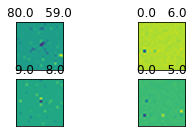

In [62]:
#this cell is for visualization purposes

exp=101
denoised_LSTAs=np.load('/media/samuele/Samuele_01/Salamander1/Best_denoised_LSTAS_berens_exp{0}.npy'.format(exp))

n_img=denoised_LSTAs.shape[1]

selcell=903

Div=10000

#thresh = 5000*Div#3500 20sigmas
#thresh = 220*Div#3500 10sigmas
thresh = 200*Div#3500 15sigmas

SKIP=True
PLOT=True

sigmas=3
radius=13

count=0
invlist = []
if exp==101:range_=np.array([815,816,817,821,823,842,850,857,865,868,869,871,883,886,887,888,889,892,894,903,905,907,913,914,915,916,917])
elif exp==102:range_=np.array([1154,1165,1167,1178,1181,1182,1183,1184,1185,1186,197,999,1000,1009,1014,1018,1029,1042,1046,1047,1051,1055,109])
else:range_=np.sort(np.array(Selected_cells[exp][0]+Selected_cells[exp][1]))

for ind, cell in enumerate(range_):
    
    if SKIP and cell!=selcell: continue
        
    #ind =np.where(exp_LSTAs_pol_ber[:,0]==cell)[0][0]
    
    if PLOT:
        fig=figure(figsize=(4,n_img))


    Coor = np.zeros([2,n_img])
    Good =  np.zeros(n_img)
    Sign = np.zeros(n_img)
    Good_centers=[]
    
    for im in np.arange(n_img):
        
        if n_img>10: ax=fig.add_subplot(4,3,im+1)
        else: ax=fig.add_subplot(4,2,im+1)
        lsta=denoised_LSTAs[ind,im]

        lsta = lsta/np.max(abs(lsta))
        if PLOT:
            ax.imshow(lsta)

        #lsta=np.abs(lsta)**2
        lsta=np.abs(lsta)


        lsta[lsta<(lsta.max()-sigmas*lsta.std())]=0
        
        Coor[0,im] = np.array(np.where(abs(lsta)==abs(lsta).max()))[0]
        Coor[1,im] = np.array(np.where(abs(lsta)==abs(lsta).max()))[1]
        
#         print(np.where(abs(lsta)==abs(lsta).max()))
#         print('Image ',str(im),denoised_LSTAs[ind,im].max(),denoised_LSTAs[ind,im].min())
#         print(Coor[:,im])
#         print(denoised_LSTAs[ind,im][int(Coor[0][im])][int(Coor[1][im])])
        
        xlsta = np.sum(lsta,axis=0)
        ylsta = np.sum(lsta,axis=1)


        CMx = np.dot(np.arange(108),xlsta)
        CMy = np.dot(np.arange(108),ylsta)

        Ix = np.dot((np.arange(108)-CMx)**2,xlsta)
        Iy = np.dot((np.arange(108)-CMy)**2,ylsta)

        Ix = Ix/ xlsta.sum()
        Iy = Iy/ ylsta.sum()
        
#         print(Ix,Iy)
        
        if Ix<thresh and Iy<thresh:
            Good[im]=1
            Sign[im]= np.sign(denoised_LSTAs[ind,im][int(Coor[0][im])][int(Coor[1][im])])
            
    

        if PLOT:
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_title( str(np.round(Ix/Div)) + '   '+str(np.round(Iy/Div)) )
            
        
    if SKIP:
        print(Good)
        print(Sign)
        print(Coor)
        print(np.delete(Coor,np.where(Good ==0)[0],axis=1  )  )
    
#-------------------------------- 
#     dist=[]
#     if Good.sum()>1:
#         good_centers=np.delete(Coor,np.where(Good ==0)[0],axis=1  )
#         for good_im in range(good_centers.shape[1]):
#             for pair in range(good_im+1,good_centers.shape[1],1):
#                 dist.append(np.sqrt( (good_centers[0,good_im]-good_centers[0,pair])**2+(good_centers[1,good_im]-good_centers[1,pair])**2 ))
    
#     if np.array(dist).mean()>3: continue
# #--------------
#     else:dist=[]
#         if np.sum(Good)>1 and Sign.max()==1 and Sign.min()==-1:

#     #         print(str(cell) + ' may invert')
#             count+=1
#             invlist.append(cell)

Total time elapsed: 5.920 s.
Total time elapsed: 5.907 s.
Total time elapsed: 6.072 s.
Total time elapsed: 6.335 s.


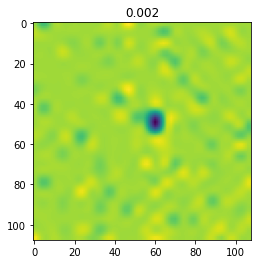

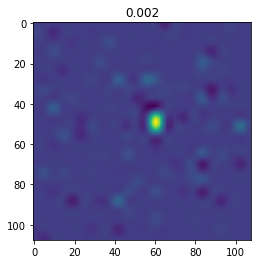

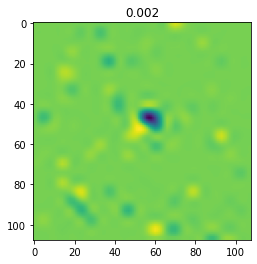

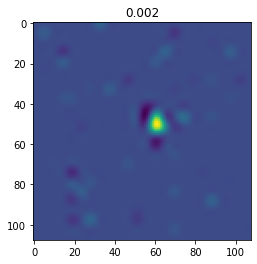

In [57]:
exp=101
s600=False
#here I visualize the performance of the model through the berens method on single image and single cell  
if exp==11:
    if s600: 
        stim=np.load('/media/samuele/Samuele_01/Exp_11/analysis/Stimulus_shaped_for_Berens_exp11_s600.npy')
        resp=np.load('/media/samuele/Samuele_01/Exp_11/analysis/Response_shaped_for_Berens_exp11_s600.npy')
        pckls_folder='/media/samuele/Samuele_01/Exp_11/analysis/s600/'
    else:
        stim=np.load('/media/samuele/Samuele_01/Exp_11/analysis/Stimulus_shaped_for_Berens_exp11_s1200.npy')
        resp=np.load('/media/samuele/Samuele_01/Exp_11/analysis/Response_shaped_for_Berens_exp11_s1200.npy')
        pckls_folder='/media/samuele/Samuele_01/Exp_11/analysis/LSTAs1200_zoom_new/'
if exp==12:
    if s600: 
        stim=np.load('/media/samuele/Samuele_01/Exp_12/analysis/Stimulus_shaped_for_Berens_exp12_s600.npy')
        resp=np.load('/media/samuele/Samuele_01/Exp_12/analysis/Response_shaped_for_Berens_exp12_s600.npy')
        pckls_folder='/media/samuele/Samuele_01/Exp_12/analysis/s600/'
    else:
        stim=np.load('/media/samuele/Samuele_01/Exp_12/analysis/Stimulus_shaped_for_Berens_exp12_s1200.npy')
        resp=np.load('/media/samuele/Samuele_01/Exp_12/analysis/Response_shaped_for_Berens_exp12_s1200.npy')
        pckls_folder='/media/samuele/Samuele_01/Exp_12/analysis/LSTAs_newcode/'
if exp==13:
    if s600: 
        stim=np.load('/media/samuele/Samuele_01/Exp_13/analysis/Stimulus_shaped_for_Berens_exp13_s600.npy')
        resp=np.load('/media/samuele/Samuele_01/Exp_13/analysis/Response_shaped_for_Berens_exp13_s600.npy')
        pckls_folder='/media/samuele/Samuele_01/Exp_13/analysis/s600/'
    else:
        stim=np.load('/media/samuele/Samuele_01/Exp_13/analysis/Stimulus_shaped_for_Berens_exp13_s1200.npy')
        resp=np.load('/media/samuele/Samuele_01/Exp_13/analysis/Response_shaped_for_Berens_exp13_s1200.npy')
        pckls_folder='/media/samuele/Samuele_01/Exp_13/analysis/LSTAs_newcode/'
if exp==14:
    stim=np.load('/media/samuele/Samuele_01/Exp_14/analysis/Stimulus_shaped_for_Berens_exp14.npy')
    resp=np.load('/media/samuele/Samuele_01/Exp_14/analysis/Response_shaped_for_Berens_exp14.npy')
    pckls_folder='/media/samuele/Samuele_01/Exp_14/analysis/s1000/'  
if exp==17:
    stim=np.load('/media/samuele/Samuele_01/Exp_17/analysis/Stimulus_shaped_for_Berens_exp17.npy')
    resp=np.load('/media/samuele/Samuele_01/Exp_17/analysis/Response_shaped_for_Berens_exp17.npy')
    pckls_folder='/media/samuele/Samuele_01/Exp_17/analysis/LSTA_1000/'    
if exp==19:
    stim=np.load('/media/samuele/Samuele_01/Exp_19/analysis/Stimulus_shaped_for_Berens_exp19.npy')
    resp=np.load('/media/samuele/Samuele_01/Exp_19/analysis/Response_shaped_for_Berens_exp19.npy')
    pckls_folder='/media/samuele/Samuele_01/Exp_19/analysis/s1000/'    
    
if exp==101:
    stim=np.load('/media/samuele/Samuele_01/Salamander1/Stimulus_shaped_for_Berens_exp101.npy')
    resp=np.load('/media/samuele/Samuele_01/Salamander1/Response_shaped_for_Berens_exp101.npy')
    pckls_folder='/media/samuele/Samuele_01/Salamander1/s1200/'       
if exp==102:
    stim=np.load('/media/samuele/Samuele_01/Salamander2/Stimulus_shaped_for_Berens_exp102.npy')
    resp=np.load('/media/samuele/Samuele_01/Salamander2/Response_shaped_for_Berens_exp102.npy')
    pckls_folder='/media/samuele/Samuele_01/Salamander2/s1200/'    

if exp>=14 and exp<100: perts=1000
else: 
    if s600: perts=600
    else: perts=1200

        
checksize=56
        
im_number=7

cell=842

for im_number in [0,1,2,3]: #range(12):

    cell_nb=0
    cell_names=[]
    for filename in os.listdir(pckls_folder):
        if filename.endswith(".pkl"):
            cell_names.append(int(filename.split('_')[2][1:] ) )
            cell_nb+=1
    cell_names=np.array(cell_names)
    
#     if exp==101: cell_names=np.array([815,816,817,821,823,842,850,857,865,868,869,871,883,886,887,888,889,892,894,903,905,907,913,914,915,916,917])
#     if exp==102: cell_names=np.array([
    stimulus=stim[im_number]
    response=resp[np.where(cell_names.argsort()==np.where(cell_names==cell)[0][0])[0][0]]
    resp_to_image=response[im_number]


    lag=0
    dims=(checksize,checksize)
    nspl=24
    df=[nspl,nspl]
    #for b in np.arange(0.008,0.028, 0.001):
    for b in [0.002]:
        lg = splineLG((stimulus/stimulus.max()).reshape(perts, checksize*checksize), resp_to_image, dims=dims, dt=lag, df=df)
        lg.fit(metric='corrcoef',
                          num_iters=1000, verbose=0, tolerance=10,
                          beta=b)
        res_ber=resize(lg.w_opt.reshape((checksize,checksize)), (108, 108), anti_aliasing=True)

        plt.figure()
        plt.imshow(res_ber)
        plt.title(b)

In [479]:
# #trial with edge detection and treshold
# denoised_LSTAs=np.load('/media/eqs8/Samuele_01/Exp_17/analysis/Best_denoised_LSTAS_berens_exp17.npy')
# img_nb=denoised_LSTAs.shape[1]

# temp_ber2=[]
# for cell_idx, cell in enumerate(np.sort(np.concatenate((As,Bs)))):
#     polarities=np.zeros((img_nb))
#     for nb,lsta in enumerate(denoised_LSTAs[cell_idx]):
#         if lsta.max()>abs(lsta.min()):
#             edges=feature.canny(lsta/lsta.max(), sigma=3.5)
#             if edges.sum()<34 and edges.sum()>5: polarities[nb]=1
#             else: polarities[nb]=0
#         else:
#             edges=feature.canny(lsta/lsta.min(), sigma=3.5)
#             if edges.sum()<34 and edges.sum()>5: polarities[nb]=-1
#             else: polarities[nb]=0
#     temp_ber2.append((cell,polarities))

# temp_ber2=np.array(temp_ber2, dtype=object)
# temp_ber2

In [478]:
# #trial with edge detection and invertions
# denoised_LSTAs=np.load('/media/eqs8/Samuele_01/Exp_17/analysis/Best_denoised_LSTAS_berens_exp17.npy')
# img_nb=denoised_LSTAs.shape[1]

# temp_ber3=[]
# for cell_idx, cell in enumerate(np.sort(np.concatenate((As,Bs)))):
#     polarities=np.zeros((img_nb))
#     for nb,lsta in enumerate(denoised_LSTAs[cell_idx]):
#         if lsta.max()>abs(lsta.min()):
#             edges=feature.canny(lsta/lsta.max(), sigma=3.5)
#             rows_diff=[]
#             cols_diff=[]
#             for rows_idx, rows in enumerate(np.diff(edges)):
#                 rows_diff.append(rows.sum())
#                 cols_diff.append(np.diff(edges, axis=0)[:,rows_idx].sum())
#             if np.array(rows_diff).max()>4 or np.array(rows_diff).max()<2 or np.array(cols_diff).max()>8: polarities[nb]=0
#             else: polarities[nb]=1
#         else:
#             edges=feature.canny(lsta/lsta.min(), sigma=3.5)
#             rows_diff=[]
#             cols_diff=[]
#             for rows_idx, rows in enumerate(np.diff(edges)):
#                 rows_diff.append(rows.sum())
#                 cols_diff.append(np.diff(edges, axis=0)[:,rows_idx].sum())
#             if np.array(rows_diff).max()>4 or np.array(rows_diff).max()<2 or np.array(cols_diff).max()>8: polarities[nb]=0
#             else: polarities[nb]=-1
#     temp_ber3.append((cell,polarities))

# temp_ber3=np.array(temp_ber3, dtype=object)
# temp_ber3

In [477]:
# #trial with squaring and sigma
# denoised_LSTAs=np.load('/media/eqs8/Samuele_01/Exp_17/analysis/Best_denoised_LSTAS_berens_exp17.npy')
# img_nb=denoised_LSTAs.shape[1]

# sigmas=32
# temp_ber=[]
# for cell_idx, cell in enumerate(np.sort(np.concatenate((As,Bs)))):
#     polarities=np.zeros((img_nb))
#     for nb,lsta_1 in enumerate(denoised_LSTAs[cell_idx]):
#         lsta=lsta_1**2*np.sign(lsta_1)
#         if lsta.max()>abs(lsta.min()):
#             if lsta.max()-sigmas*lsta.std()>0: polarities[nb]=1
#             else: polarities[nb]=0
#         else:
#             if lsta.min()+sigmas*lsta.std()<0: polarities[nb]=-1
#             else: polarities[nb]=0
#     temp_ber.append((cell,polarities))

# temp_ber=np.array(temp_ber, dtype=object)
# temp_ber

In [156]:
# #trial with squaring and sigma and position treshhold
# denoised_LSTAs=np.load('/media/eqs8/Samuele_01/Exp_17/analysis/Best_denoised_LSTAS_berens_exp17.npy')
# img_nb=denoised_LSTAs.shape[1]

# sigmas=15
# sparseness=.9
# temp_ber4=[]
# for cell_idx, cell in enumerate(np.sort(np.concatenate((As,Bs)))):
#     polarities=np.zeros((img_nb))
#     for nb,lsta_1 in enumerate(denoised_LSTAs[cell_idx]):
#         lsta=lsta_1**4*np.sign(lsta_1)
#         if lsta.max()>abs(lsta.min()):
#             lsta[lsta<(lsta.max()-sigmas*lsta.std())]=0
#             if list(np.where(lsta!=0)[0]):
#                 if (np.where(lsta.flatten()!=0)[0]%108).std()<=sparseness and (np.where(lsta.flatten()!=0)[0]/108).astype(int).std()<=sparseness: polarities[nb]=1
#                 else:polarities[nb]=0
#             else:polarities[nb]=0
#         else:
#             lsta[lsta>(lsta.min()+sigmas*lsta.std())]=0
#             if list(np.where(lsta!=0)[0]):
#                 if (np.where(lsta.flatten()!=0)[0]%108).std()<=sparseness and (np.where(lsta.flatten()!=0)[0]/108).astype(int).std()<=sparseness: polarities[nb]=-1
#                 else:polarities[nb]=0
#             else:polarities[nb]=0
#     temp_ber4.append((cell,polarities))

# temp_ber4=np.array(temp_ber4, dtype=object)

In [ ]:
# Blist = [   4,   30,  113,  116,  117,  141,  145,  200,  210,  339,  349,
#         350,  364,  402,  436,  499,  500,  532,  561,  567,  641,  706,
#         737,  743,  753,  754,  767,  776,  794,  800,  815,  862,  874,
#         892,  901,  910,  942,  956,  962,  991,  992,  998, 1004, 1014,
#        1021, 1029, 1031]
# real_inverting=[4,30,116,285,339,364,561,567,706,754,776,862,874,892,910,956,962,991,1004,1009,1014,1031]

# len(real_inverting)
# def Intersection(lst1, lst2):
#     return set(lst1).intersection(lst2)

# circle_out =[499,743,753,757,794,800,815,942,145,200,500,901,992,998]

In [ ]:
# ##RUN ONLY IF THE LABELS ARE NOT ALREADY PRESENT (LIKELY)!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

# #this authomatic detection relies on the STA ellipse

# #the number of the experiment has to be chosen in the cell above
# if exp==11:
#     pckls_folder='/media/eqs8/Samuele_01/Exp_11/analysis/LSTAs1200_zoom_new/'
#     #the folder in which the LSTAs are stored
#     RF_fit_folder = '/media/eqs8/Samuele_01/Exp_11/analysis/STA2_withellipse/'
#     codename = 'exp11_m5_RF_fit' 
#     #the folder in which the RF fits are stored and the file's name
# if exp==12:
#     pckls_folder='/media/eqs8/Samuele_01/Exp_12/analysis/LSTAs_newcode/'
#     RF_fit_folder = '/media/eqs8/Samuele_01/Exp_12/analysis/RF_withellipse_newcode/'
#     codename = 'exp12_m5_RF_fit' 
# if exp==13:
#     pckls_folder='/media/eqs8/Samuele_01/Exp_13/analysis/LSTAs_newcode/'
#     RF_fit_folder = '/media/eqs8/Samuele_01/Exp_13/analysis/Sam_analysis_trial/STAs_withellipses_new/'
#     codename = 'exp13_m5_RF_fit' 
# if exp==17:
#     pckls_folder='/media/eqs8/Samuele_01/Exp_17/analysis/LSTA_1000_trial/'
#     RF_fit_folder = '/media/eqs8/Samuele_01/Exp_17/analysis/RF_m5/'
#     codename = 'exp17_m5_RF_fit' 
# if exp==19:
#     #pckls_folder= GET THE PICKLES OF THE LSTAS
#     RF_fit_folder = '/media/eqs8/Samuele_01/Exp_19/analysis/RF_FIT/'
#     codename = 'exp19_m1_RF_fit' 
    
# RF_fit,sharpval = load_obj(RF_fit_folder +codename)

# if exp>=14:  
#     check_resize_factor = 1                       #
#     image_translation = 72       / 12           # in check units of lsta (72px decalage/#pixpercheck)
#     patim_size = 72
    
# if 10<exp<14:
#     check_resize_factor = (864/73) / 12                       #73/60
#     image_translation = 72       / (864/73)           # in check units of lsta (72px decalage/#pixpercheck)
#     patim_size = 72
    
# ellipse_resize=1
# #do I want to have my ellipse bigger?

# exp_LSTAs_pol=[]
# for filename in os.listdir(pckls_folder):
#     if filename.endswith(".pkl"): 
#         cell=int(filename.split('_')[2][1:])
#         if cell in As or cell in Bs:
#             exp_lstas=np.load(pckls_folder+filename,allow_pickle=True)
#             coor = (np.array(RF_fit[cell][0])) 
#             Xell,Yell= (np.array((RF_fit[cell][1]))) 

#     #-------------------------------------------
#     # resize and convert to python coordinates
#     #-------------------------------------------
#     # top left corner in Matlab is: 0.5,0.5
#     # in matlab is -0.5,-0.5. Have to shift, resize. And then reshift (inversion was done at RF_fit step)

#             coor_new = (coor - [0.5,0.5]) *check_resize_factor + [0.5,0.5] + [image_translation,image_translation]

#             Xell = ((Xell-(coor[0]))*ellipse_resize )*check_resize_factor + coor_new[0]
#             Yell = ((Yell-(coor[1]))*ellipse_resize )*check_resize_factor + coor_new[1]
#     #-------------------------------------------
#             if exp<14:responses=np.zeros((7))
#             if exp>14:responses=np.zeros((8))
#             for nb,im in enumerate(exp_lstas):
#                 filt=[]
#                 for i,j in enumerate(im.flatten()):
#                     if Yell.min()<i/patim_size<Yell.max() and Xell.min()<i%patim_size<Xell.max():
#                         filt.append(j)
#                 filt=np.array(filt)
#                 nb_pix=len(filt)
#                 #if cell==388: print(filt.mean(),im.std())
#                 if filt.mean()>0 and (filt.mean()-3*im.std()/np.sqrt(nb_pix))>0: responses[nb]=1  
#                 elif filt.mean()<0 and (filt.mean()+3*im.std()/np.sqrt(nb_pix))<0: responses[nb]=-1
#                 else: responses[nb]=0 
#                 #print(filt.mean(),im.mean(),im.std())'''
#             print(cell,responses)
#             #print(nb_pix)
#             exp_LSTAs_pol.append((cell,responses))
#         else: continue
        
# exp_LSTAs_pol=np.array(exp_LSTAs_pol, dtype=object)

# #np.save('/media/eqs8/Samuele_01/Exp_{0}/analysis/exp_LSTAS_labels_ellipse_exp{1}'.format(exp,exp),exp_LSTAs_pol)

In [ ]:
# #this authomatic detection uses a gaussian blur + a thresholding system
# (IMPLAMENTED BUT NEVER USED BECAUSE WORSE THAN THE OTHER)
# exp=11
# if exp==11:
#     pckls_folder='/media/eqs8/Samuele_01/Exp_11/analysis/LSTAs1200_zoom_new/'
#     #the folder in which the LSTAs are stored

# #     RF_fit_folder = '/media/eqs8/Samuele_01/Exp_11/analysis/STA2_withellipse/'
# #     codename = 'exp11_m5_RF_fit' 
#     #the folder in which the RF fits are stored and the file's name
# if exp==12:
#     pckls_folder='/media/eqs8/Samuele_01/Exp_12/analysis/LSTAs_newcode/'
# if exp==13:
#     pckls_folder='/media/eqs8/Samuele_01/Exp_13/analysis/LSTAs_newcode/'
# if exp=='Bapt':
#     pckls_folder='/media/eqs8/Samuele_01/Exp_11/analysis/LSTAs1200_zoom_new/'
    
# labels=[]
# # for filename in os.listdir(pckls_folder)[246:247]:    #to threshold only one cell
# for filename in os.listdir(pckls_folder):
#     if filename.endswith(".pkl"): 
#         cell=int(filename.split('_')[2][1:])
#         print(cell)
#         exp_lstas=np.load(pckls_folder+filename,allow_pickle=True)
# #         idx=6        
# #         exp_lstas.shape
# #         #print(exp_lstas[idx])
# #         #print(exp_lstas[idx].mean(),exp_lstas[idx].std(),exp_lstas[idx].max(),exp_lstas[idx].min() )
# #         plt.figure()
# #         plt.imshow(exp_lstas[idx])

#         #import skimage.filters
#         onecell_labels=[]
#         for img_idx in range(exp_lstas.shape[0]):
#         #for img_idx in range(2,4,1):                     #to threshold only one image of a cell

#             new_img_1=gaussian(exp_lstas[img_idx],sigma=1)
#             new_img=resize(new_img_1, (108, 108), anti_aliasing=True)
# #             plt.figure()
# #             plt.imshow(new_img)
# #             print(new_img.mean(),new_img.std(),new_img.max(),new_img.min())

# #             check=np.zeros((np.size(new_img)))
#             on_filt=[]
#             off_filt=[]
#             for spot,pix in enumerate(new_img.flatten()):
#                 if new_img.max()>abs(new_img.min()):
#                     if pix>(new_img.max()-2*new_img.std()):
# #                         check[spot]=1                   #comment
#                         on_filt.append([spot,pix])
#                 if new_img.max()< abs(new_img.min()):
#                     if pix<(new_img.min()+2*new_img.std()):
# #                         check[spot]=1                   #comment
#                         off_filt.append([spot,pix])
#             if on_filt:
#                 on_filt=np.array(on_filt)
#                 x_max=int(on_filt[on_filt[:,1].argmax(),0]%108)
#                 y_max=int(on_filt[on_filt[:,1].argmax(),0]/108)
#                 x_shifts=abs((on_filt[:,0]%108)-x_max)
#                 y_shifts=abs((on_filt[:,0]/108).astype(int)-y_max)
#                 sign=0
#                 nonsign=0
#                 for i in range(np.size(x_shifts)):
#                     #print(x_shifts[i],y_shifts[i])
#                     if x_shifts[i]+y_shifts[i]<6: sign+=1
#                     else:nonsign+=1
#                     #print(nonsign)
#             #     if (on_filt[:,0]%108).std()>3: print('NO_LSTA:{0}'.format(on_filt.shape))
#                 if nonsign>sign or x_max<5 or x_max>95 or y_max<5 or y_max>95: onecell_labels.append(0)#print('NO_LSTA:{0}'.format(on_filt.shape))
#                 else: onecell_labels.append(1) #print('ON:{0}'.format(on_filt.shape))
#                 #print(sign,nonsign)
#             if off_filt:
#                 off_filt=np.array(off_filt)
#                 x_max=int(off_filt[off_filt[:,1].argmax(),0]%108)
#                 y_max=int(off_filt[off_filt[:,1].argmax(),0]/108)
#                 x_shifts=abs((off_filt[:,0]%108)-x_max)
#                 y_shifts=abs((off_filt[:,0]/108).astype(int)-y_max)
#                 sign=0
#                 nonsign=0
#                 for i in range(np.size(x_shifts)):
#                     if x_shifts[i]+y_shifts[i]<6: sign+=1
#                     else:nonsign+=1
#             #     if (off_filt[:,0]%108).std()>3: print('NO_LSTA:{0}'.format(off_filt.shape))
#                 if nonsign>sign or x_max<5 or x_max>95 or y_max<5 or y_max>95: onecell_labels.append(0)#print('NO_LSTA:{0}'.format(off_filt.shape))
#                 else: onecell_labels.append(-1) #print('OFF:{0}, sign:{1}'.format(off_filt.shape,sign))
#                 #print(sign,nonsign)
# #             plt.figure()
# #             plt.imshow(check.reshape(108,108))
#         labels.append((cell,np.array(onecell_labels)))
# labels=np.array(labels, dtype=object)
# #np.save('/media/eqs8/Samuele_01/Exp_{0}/analysis/exp_LSTAS_labels_blu+tresh_exp{1}'.format(exp,exp),labels)

# Load the labels calculated with the Berens method (RFEst)

In [3]:
exp=11
if exp>100:
    exp_LSTAs_pol_ber=np.load('/media/samuele/Samuele_01/Salamander{0}/exp_LSTAS_labels_berens_exp{1}.npy'.format(exp-100,exp),allow_pickle=True)
else:    
    exp_LSTAs_pol_ber=np.load('/media/samuele/Samuele_01/Exp_{0}/analysis/exp_LSTAS_labels_berens_exp{0}.npy'.format(exp),allow_pickle=True)
#exp_LSTAs_pol_ber

# Count the LSTAs obtained in a given experiment and their polarity

In [4]:
#The experiment has to be chosen in the cell above
labels=np.array(exp_LSTAs_pol_ber, dtype=object)

print('Experiment {0}:'.format(exp))
print('Number of cells analyzed (As and Bs): {0}'.format(labels.shape[0]))

tot_cells=labels.shape[0]
no_lstas=0
yes_lstas=0

for cell_score in labels:
    if np.all(cell_score[1]==0.):
        no_lstas+=1
    else:
        yes_lstas+=1
print('{0} cells did not show a local STA ({1:.3}% of the total)'.format(no_lstas,no_lstas/tot_cells*100))
print('{0} cells showed LSTAs (both inverting and not)) ({1:.3}% of the total)'.format(yes_lstas,yes_lstas/tot_cells*100))

Experiment 11:
Number of cells analyzed (As and Bs): 94
35 cells did not show a local STA (37.2% of the total)
59 cells showed LSTAs (both inverting and not)) (62.8% of the total)


## List of the cells that have LSTAs

In [101]:
list_=[]
for scores in exp_LSTAs_pol_ber:
    if np.all(scores[1]==0.):continue
    else:list_.append(scores[0])
        
np.array(list_)

array([1154, 1165, 1167, 1178, 1181, 1182, 1183, 1184, 1185, 1186,  197,
        999, 1000, 1009, 1014, 1018, 1029, 1042, 1046, 1047, 1051, 1055,
        109])

## Assessment of the shift among LSTAs of the same cell

In [70]:
exp=11

berens_LSTAS=np.load('/media/samuele/Samuele_01/Exp_{0}/analysis/Best_denoised_LSTAS_berens_exp{0}_s1200.npy'.format(exp))
exp_LSTAs_pol_ber=np.load('/media/samuele/Samuele_01/Exp_{0}/analysis/exp_LSTAS_labels_berens_exp{0}.npy'.format(exp),allow_pickle=True)

x, y = np.meshgrid(np.linspace(0,108,108), np.linspace(0,108,108))
def gaussian_filt( x,y ,x0,y0,sx,sy,theta,amp):
    x1=x*np.cos(theta)-y*np.sin(theta)-x0*np.cos(theta)+y0*np.sin(theta)
    y1=y*np.cos(theta)+x*np.sin(theta)-y0*np.cos(theta)-x0*np.sin(theta)
    return amp*np.exp(-((x1**2. / (2. * sx**2.) + (y1)**2. / (2. * sy**2.))))
def gaussian_filt_1( input_ ,x0,y0,sx,sy,theta,amp):
    x1=input_[0]*np.cos(theta)-input_[1]*np.sin(theta)-x0*np.cos(theta)+y0*np.sin(theta)
    y1=input_[1]*np.cos(theta)+input_[0]*np.sin(theta)-y0*np.cos(theta)-x0*np.sin(theta)
    return (amp*np.exp(-((x1**2. / (2. * sx**2.) + (y1)**2. / (2. * sy**2.))))).ravel()

shifts_3=[]
for i in range(berens_LSTAS.shape[0]):
    if abs(exp_LSTAs_pol_ber[i,1]).sum()==0 or abs(exp_LSTAs_pol_ber[i,1]).sum()==1: continue 
    #these cells have only one detected Lsta or none and so they are not useful to our analysis
    else:
        selected_LSTAS=np.delete(berens_LSTAS[i],np.where(exp_LSTAs_pol_ber[i,1]==0.)[0], axis=0)
        #redenoised_lstas=np.zeros(selected_LSTAS.shape)
        redenoised_lstas=[]
        for idx,lsta in enumerate(selected_LSTAS):
            if abs(lsta.min())> abs(lsta.max()): p0=[lsta.argmin()%108, int(lsta.argmin()/108),2,2, 0,-1]
            if abs(lsta.max())> abs(lsta.min()): p0=[lsta.argmax()%108, int(lsta.argmax()/108),2,2, 0,1]
            try:
                best_vals, covar = curve_fit(gaussian_filt_1, np.array((x, y)), lsta.ravel(), p0=p0)
#                 redenoised_lstas[idx]=gaussian_filt_1((x,y), *best_vals).reshape(108,108)
                redenoised_lstas.append(gaussian_filt_1((x,y), *best_vals).reshape(108,108))
            except: continue        
        redenoised_lstas=np.array(redenoised_lstas)
        nb_remaining_images=redenoised_lstas.shape[0]
        for j, exp_lsta in enumerate(redenoised_lstas):
            if j==(nb_remaining_images-1):continue
            else:
                for t in range(j+1,nb_remaining_images):
                    shifts_3.append(abs(np.dot((exp_lsta/np.linalg.norm(exp_lsta)).ravel(), (redenoised_lstas[t]/np.linalg.norm(redenoised_lstas[t])).ravel())))                  
                                                        
exp=13

berens_LSTAS=np.load('/media/samuele/Samuele_01/Exp_{0}/analysis/Best_denoised_LSTAS_berens_exp{0}_s1200.npy'.format(exp))
exp_LSTAs_pol_ber=np.load('/media/samuele/Samuele_01/Exp_{0}/analysis/exp_LSTAS_labels_berens_exp{0}.npy'.format(exp),allow_pickle=True)

shifts=[]
for i in range(berens_LSTAS.shape[0]):
    if abs(exp_LSTAs_pol_ber[i,1]).sum()==0 or abs(exp_LSTAs_pol_ber[i,1]).sum()==1: continue 
    #these cells have only one detected Lsta or none and so they are not useful to our analysis
    else:
        selected_LSTAS=np.delete(berens_LSTAS[i],np.where(exp_LSTAs_pol_ber[i,1]==0.)[0], axis=0)
        #redenoised_lstas=np.zeros(selected_LSTAS.shape)
        redenoised_lstas=[]
        for idx,lsta in enumerate(selected_LSTAS):
            if abs(lsta.min())> abs(lsta.max()): p0=[lsta.argmin()%108, int(lsta.argmin()/108),2,2, 0,-1]
            if abs(lsta.max())> abs(lsta.min()): p0=[lsta.argmax()%108, int(lsta.argmax()/108),2,2, 0,1]
            try:
                best_vals, covar = curve_fit(gaussian_filt_1, np.array((x, y)), lsta.ravel(), p0=p0)
#                 redenoised_lstas[idx]=gaussian_filt_1((x,y), *best_vals).reshape(108,108)
                redenoised_lstas.append(gaussian_filt_1((x,y), *best_vals).reshape(108,108))
            except: continue        
        redenoised_lstas=np.array(redenoised_lstas)
        nb_remaining_images=redenoised_lstas.shape[0]
        for j, exp_lsta in enumerate(redenoised_lstas):
            if j==(nb_remaining_images-1):continue
            else:
                for t in range(j+1,nb_remaining_images):
                    shifts.append(abs(np.dot((exp_lsta/np.linalg.norm(exp_lsta)).ravel(), (redenoised_lstas[t]/np.linalg.norm(redenoised_lstas[t])).ravel())))                  
                                                        

exp=17

berens_LSTAS=np.load('/media/samuele/Samuele_01/Exp_{0}/analysis/Best_denoised_LSTAS_berens_exp{0}.npy'.format(exp))
exp_LSTAs_pol_ber=np.load('/media/samuele/Samuele_01/Exp_{0}/analysis/exp_LSTAS_labels_berens_exp{0}.npy'.format(exp),allow_pickle=True)

shifts_2=[]
for i in range(berens_LSTAS.shape[0]):
    if abs(exp_LSTAs_pol_ber[i,1]).sum()==0 or abs(exp_LSTAs_pol_ber[i,1]).sum()==1: continue 
    #these cells have only one detected Lsta or none and so they are not useful to our analysis
    else:
        selected_LSTAS=np.delete(berens_LSTAS[i],np.where(exp_LSTAs_pol_ber[i,1]==0.)[0], axis=0)
        #redenoised_lstas=np.zeros(selected_LSTAS.shape)
        redenoised_lstas=[]
        for idx,lsta in enumerate(selected_LSTAS):
            if abs(lsta.min())> abs(lsta.max()): p0=[lsta.argmin()%108, int(lsta.argmin()/108),2,2, 0,-1]
            if abs(lsta.max())> abs(lsta.min()): p0=[lsta.argmax()%108, int(lsta.argmax()/108),2,2, 0,1]
            try:
                best_vals, covar = curve_fit(gaussian_filt_1, np.array((x, y)), lsta.ravel(), p0=p0)
#                 redenoised_lstas[idx]=gaussian_filt_1((x,y), *best_vals).reshape(108,108)
                redenoised_lstas.append(gaussian_filt_1((x,y), *best_vals).reshape(108,108))
            except: continue        
        redenoised_lstas=np.array(redenoised_lstas)
        nb_remaining_images=redenoised_lstas.shape[0]
        for j, exp_lsta in enumerate(redenoised_lstas):
            if j==(nb_remaining_images-1):continue
            else:
                for t in range(j+1,nb_remaining_images):
                    shifts_2.append(abs(np.dot((exp_lsta/np.linalg.norm(exp_lsta)).ravel(), (redenoised_lstas[t]/np.linalg.norm(redenoised_lstas[t])).ravel())))                  
                                                        

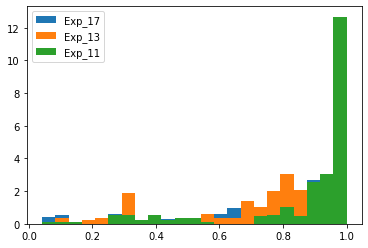

In [71]:
bin_=linspace(0,1,25)[1:]
plt.figure()
plt.hist(shifts_2,bins=bin_,label='Exp_17',density=True)
plt.hist(shifts,bins=bin_,label='Exp_13',density=True)
plt.hist(shifts_3,bins=bin_,label='Exp_11',density=True)
plt.legend()

(array([0.10884354, 0.43537415, 0.27210884, 0.27210884, 0.54421769,
        0.8707483 , 1.14285714, 0.21768707, 0.10884354, 0.16326531,
        0.16326531, 0.21768707, 0.27210884, 0.59863946, 0.97959184,
        1.08843537, 0.92517007, 1.63265306, 2.12244898, 2.28571429,
        1.79591837, 2.50340136, 5.27891156]),
 array([0.04166667, 0.08333333, 0.125     , 0.16666667, 0.20833333,
        0.25      , 0.29166667, 0.33333333, 0.375     , 0.41666667,
        0.45833333, 0.5       , 0.54166667, 0.58333333, 0.625     ,
        0.66666667, 0.70833333, 0.75      , 0.79166667, 0.83333333,
        0.875     , 0.91666667, 0.95833333, 1.        ]),
 <BarContainer object of 23 artists>)

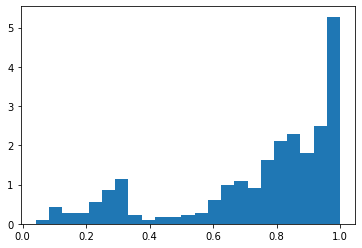

In [85]:
tot=shifts+shifts_2+shifts_3
plt.figure()
plt.hist(shifts_2,bins=bin_,label='11+13+17',density=True)

## Quantification of CNN performance on psths. (on population)

In [117]:
exp= 102
if exp==11:
    results_folder="/media/samuele/Samuele_01/Exp_11/analysis/cnn_12mixed_tr19/run_019"
    dataset = Dataset.load("/media/samuele/Samuele_01/Exp_11/analysis/data2_12mixed_tr19.pkl")
# if exp==12:
#     results_folder="/media/samuele/Samuele_01/Exp_12/analysis/cnn_32mixed_tr21/run_060"
#     dataset = Dataset.load("/media/eqs8/Samuele_01/Exp_12/analysis/data2_32mixed_tr21.pkl")
if exp==13:
    results_folder="/media/samuele/Samuele_01/Exp_13/analysis/cnn_9OFF_tr1/run_097"
    dataset = Dataset.load("/media/samuele/Samuele_01/Exp_13/analysis/data2_select_tr1.pkl")
if exp==17:
    results_folder="/media/samuele/Samuele_01/Exp_17/analysis/cnn_41mixed_tr28_repeat/run_026"
    dataset = Dataset.load("/media/samuele/Samuele_01/Exp_17/analysis/data2_41mixed_tr28.pkl")
if exp==19:
    results_folder="/media/samuele/Samuele_01/Exp_19/analysis/cnn_28mixed_tr35/run_019"
    dataset = Dataset.load("/media/samuele/Samuele_01/Exp_19/analysis/data2_28mixed_tr35.pkl")
if exp==101:
    results_folder="/media/samuele/BC_Samuele/20190523_goodone/analyses/cnn_sys_ident/20200616_025316/run_075"
    dataset = Dataset.load("/media/samuele/BC_Samuele/20190523_goodone/analyses/flashed_images/fi/data.pkl")
if exp==102:
    results_folder="/media/samuele/Samuele_01/Salamander2/cnn_23mixed_tr34/run_030"
    dataset = Dataset.load("/media/samuele/Samuele_01/Salamander2/data2_23mixed_tr34.pkl")

dataset.select_cells('all')
# train_x, train_y = dataset.train()
# val_x, val_y = dataset.val()
test_x, test_y = dataset.test(averages=False)

#here I reshape the pickle outputs that have a weird 1
# train_x=train_x[:,:,:,0]
# val_x=val_x[:,:,:,0]
test_x=test_x[:,:,:,0]

print(test_y.shape)

cnn_test_predictions=np.load(os.path.join(results_folder, 'test_predictions.npy'))
#these are the CNN results on the testing set
cnn_test_predictions=np.mean(cnn_test_predictions,axis=0)
#I average across repetitions because the model is not stochastic and so for the same image gives always the same prediction
print(cnn_test_predictions.shape)

even_test_y = np.mean(test_y[0::2, :, :], axis=0)  # mean over even repetitions
odd_test_y = np.mean(test_y[1::2, :, :], axis=0)  # mean over odd repetitions
reliabilities = []
accuracies_o = []
accuracies_e = []
nb_cells=test_y.shape[-1]
for cell_nb in range(0, nb_cells):
    reliability = corrcoef(even_test_y[:, cell_nb], odd_test_y[:, cell_nb])
    accuracy_o = corrcoef(cnn_test_predictions[:, cell_nb], odd_test_y[:, cell_nb])
    accuracy_e = corrcoef(cnn_test_predictions[:, cell_nb], even_test_y[:, cell_nb])
    reliabilities.append(reliability)
    accuracies_o.append(accuracy_o)
    accuracies_e.append(accuracy_e)
reliabilities = np.array(reliabilities)
accuracies_o = np.array(accuracies_o)
accuracies_e = np.array(accuracies_e)

max_explainable_var=2/(1+np.sqrt(1/reliabilities**2))
#the variance in the true data that is explainable. The unexplainable part is due to noise

nc_cnn_predicted_variance=(0.5*(accuracies_o+accuracies_e))/np.sqrt(reliabilities)
#the variance that is actually explained by the model

cnn_performance=nc_cnn_predicted_variance/max_explainable_var
#the percentage of explainable variance that is explained by the model

print(cnn_performance)
print(cnn_performance.mean())
#print(cnn_test_predictions[:, cell_nb])

(20, 30, 23)
(30, 23)
[0.56528466 0.86413039 0.91429371 0.84353785 0.90500531 0.82807594
 0.84496323 0.84932576 0.94668149 0.83777781 0.5712198  0.95256843
 0.86931835 0.80343213 0.65601749 0.83156825 0.78196085 0.92717897
 0.81340661 0.80559441 0.88044434 0.81257536 0.57932909]
0.8123343586028866


## Quantification of LN performance on psths. (on population)¶

In [133]:
exp= 13
if exp==11:
    results_folder="/media/samuele/Samuele_01/Exp_11/analysis/ln_12mixed_tr19/"
    dataset = Dataset.load("/media/samuele/Samuele_01/Exp_11/analysis/data2_12mixed_tr19.pkl")
# if exp==12:
#     results_folder="/media/samuele/Samuele_01/Exp_12/analysis/ln_32mixed_tr21/"
#     dataset = Dataset.load("/media/samuele/Samuele_01/Exp_12/analysis/data2_32mixed_tr21.pkl")
if exp==13:
    results_folder="/media/samuele/Samuele_01/Exp_13/analysis/ln_9OFF_tr1/"
    dataset = Dataset.load("/media/samuele/Samuele_01/Exp_13/analysis/data2_select_tr1.pkl")
if exp==17:
    results_folder="/media/samuele/Samuele_01/Exp_17/analysis/ln_41mixed_tr28/"
    dataset = Dataset.load("/media/samuele/Samuele_01/Exp_17/analysis/data2_41mixed_tr28.pkl")
if exp==19:
    results_folder="/media/samuele/Samuele_01/Exp_19/analysis/ln_28mixed_tr35/"
    dataset = Dataset.load("/media/samuele/Samuele_01/Exp_19/analysis/data2_28mixed_tr35.pkl")
if exp==101:
    results_folder="/media/samuele/Samuele_01/Salamander1/ln_exp101/"
    dataset = Dataset.load("/media/samuele/Samuele_01/Salamander1/data.pkl")
if exp==102:
    results_folder="/media/samuele/Samuele_01/Salamander2/ln_23mixed_tr34/"
    dataset = Dataset.load("/media/samuele/Samuele_01/Salamander2/data2_23mixed_tr34.pkl")


dataset.select_cells('all')
test_x, test_y = dataset.test(averages=False)
nb_cells=test_y.shape[-1]
#print(test_y.shape)

stim_trials_f= open(results_folder + 'baseline_ln_table_seed_exp{0}.csv'.format(exp))
stim_trials_f = csv.reader(stim_trials_f,delimiter=",")
stim_trials=[]
for row in stim_trials_f:
    stim_trials.append(np.array(row))
stim_trials = np.array(stim_trials[1:])
#print(stim_trials)

ln_pop_perf=[]
for cell_nb in range(nb_cells):
    dataset.select_cells([cell_nb])
    test_x, test_y = dataset.test(averages=False)
    test_x=test_x[:,:,:,0]
    best_run=int(stim_trials[cell_nb][2])
    if best_run==0: 
        continue            #these are the cells for which the LN model did not converge
    else:
        results_f=results_folder+"c{0:02d}/run_{1:03d}/".format(cell_nb,best_run)
#         print(results_f)
        ln_test_predictions=np.load(os.path.join(results_f, 'test_predictions.npy'))
        #these are the LN results on the testing set
        ln_test_predictions=np.mean(ln_test_predictions,axis=0)[:,0]
        #I average across repetitions because the model is not stochastic and so for the same image gives always the same prediction
        #print(ln_test_predictions.shape)

        even_test_y = np.mean(test_y[0::2, :], axis=0)[:,0]  # mean over even repetitions
        odd_test_y = np.mean(test_y[1::2, :], axis=0)[:,0]   # mean over odd repetitions
        reliability = corrcoef(even_test_y, odd_test_y)
        accuracy_o = corrcoef(ln_test_predictions, odd_test_y)
        accuracy_e = corrcoef(ln_test_predictions, even_test_y)

        max_explainable_var=2/(1+np.sqrt(1/reliability**2))
        #the variance in the true data that is explainable. The unexplainable part is due to noise

        nc_ln_predicted_variance=(0.5*(accuracy_o+accuracy_e))/np.sqrt(reliability)
        #the variance that is actually explained by the model

        ln_performance=nc_ln_predicted_variance/max_explainable_var
        #the percentage of explainable variance that is explained by the model
        
        print(ln_performance)
        ln_pop_perf.append([cell_nb, ln_performance])
print('Population performance of the LN model:  {0}'.format(np.array(ln_pop_perf)[:,1].mean()))

0.9661171372264133
0.8621423741141351
0.926987218040583
0.5415750059541351
0.42757242555348934
0.8175455924213747
0.97333789169088
Population performance of the LN model:  0.7878968064287158


In [19]:
# #estimation of the model performance in predicting the LSTAs using the STA ellipse
# #not used, because overperformed by the gaussian fit

# exp=13
# if exp==11:
#     RF_fit_folder = '/media/eqs8/Samuele_01/Exp_11/analysis/STA2_withellipse/'
#     codename = 'exp11_m5_RF_fit' 
#     model_cell_list=[3,44,68,81,95,134,153,199,310,322,388,478]
#     results_folder="/media/eqs8/Samuele_01/Exp_11/analysis/cnn_12mixed_tr19/run_019"
# if exp==12:
#     RF_fit_folder = '/media/eqs8/Samuele_01/Exp_12/analysis/RF_withellipse_newcode/'
#     codename = 'exp12_m5_RF_fit' 
#     model_cell_list=[33,46,74,82,87,93,95,111,120,125,158,173,179,184,192,196,200,202,245,266,271,287,335,354,372,380,415,450,459,460,570,657]
#     results_folder="/media/eqs8/Samuele_01/Exp_12/analysis/cnn_32mixed_tr21/run_060"
# if exp==13:
#     RF_fit_folder = '/media/eqs8/Samuele_01/Exp_13/analysis/Sam_analysis_trial/STAs_withellipses_new/'
#     codename = 'exp13_m5_RF_fit' 
#     model_cell_list=[91,186,202,225,257,621,634,684,748]
#     results_folder="/media/eqs8/Samuele_01/Exp_13/analysis/cnn_9OFF_tr1/run_097"
# if exp==19: 
#     model_cell_list=[1,6,33,35,44,65,79,83,89,106,142,145,153,201,211,237,253,285,293,299,311,318,329,338,360,385,390,416,432,435,436,469,493,604]
# if exp=='Bapt':
#     RF_fit_folder = '/media/eqs8/Samuele_01/Exp_11/analysis/STA2_withellipse/'
#     codename = 'exp13_m5_RF_fit' 
#     model_cell_list=[]
#     results_folder="/media/eqs8/Samuele_01/Bapt/analysis/cnn_12mixed_tr19/run_019"

# corr_coeffs_ellipse=np.zeros((len(model_cell_list),7))
# RF_fit,sharpval = load_obj(RF_fit_folder +codename)
# test_lstas_withgray=np.load(os.path.join(results_folder, 'lstas.npy'))
# pert_testing=[30,0,1,19,8,12,11]
# for idx,cell in enumerate(model_cell_list):
#     coor = (np.array(RF_fit[cell][0])) 
#     Xell,Yell= (np.array((RF_fit[cell][1]))) 
#     coor_new = (coor - [0.5,0.5]) *check_resize_factor + [0.5,0.5] + [image_translation,image_translation]
#     Xell = (  ((Xell-(coor[0]))*ellipse_resize )*check_resize_factor + coor_new[0]  )*108/72
#     Yell = (  ((Yell-(coor[1]))*ellipse_resize )*check_resize_factor + coor_new[1]  )*108/72

#     exp_lstas=np.load(pckls_folder+'exp{0}_m2_c{1}_s1200_LSTAs.pkl'.format(exp,cell),allow_pickle=True)
#     for nb,im in enumerate(exp_lstas):
#         res_img=resize(im, (108, 108), anti_aliasing=True)
# # plt.figure()  
# # plt.imshow(res_img)
# # plt.plot(Xell,Yell,'black')
# # plt.figure()
# # plt.imshow(mask.reshape(108,108))
# # plt.plot(Xell,Yell,'red')
# # plt.figure()
# # plt.imshow(test_lstas_withgray[4,pert_testing[6]])
# # plt.plot(Xell,Yell,'red')
#         filt_exp=[]
#         filt_mod=[]
#         for q,w in enumerate(res_img.flatten()):
#             if Yell.min()<q/108<Yell.max() and Xell.min()<q%108<Xell.max():
#                 filt_exp.append(w) 
#                 filt_mod.append(test_lstas_withgray[idx,pert_testing[nb]].flatten()[q])

#         filt_exp=np.array(filt_exp)
#         filt_mod=np.array(filt_mod)

#         corr_coeffs_ellipse[idx,nb]=np.corrcoef(filt_exp,filt_mod)[0,1]*abs(exp_LSTAs_pol[np.where(exp_LSTAs_pol[:,0]==cell)[0][0],1][nb])
#         #print(abs(exp_LSTAs_pol[np.where(exp_LSTAs_pol[:,0]==cell)[0][0],1][nb]))

In [87]:
# #estimation of the model performance in predicting the LSTAs using the denoising +thresholding
# #not used, because overperformed by the gaussian fit

# exp=13
# if exp==11:
#     model_cell_list=[3,44,68,81,95,134,153,199,310,322,388,478]
#     results_folder="/media/eqs8/Samuele_01/Exp_11/analysis/cnn_12mixed_tr19/run_019"
# if exp==12:
#     model_cell_list=[33,46,74,82,87,93,95,111,120,125,158,173,179,184,192,196,200,202,245,266,271,287,335,354,372,380,415,450,459,460,570,657]
#     results_folder="/media/eqs8/Samuele_01/Exp_12/analysis/cnn_32mixed_tr21/run_060"
# if exp==13:
#     model_cell_list=[91,186,202,225,257,621,634,684,748]
#     results_folder="/media/eqs8/Samuele_01/Exp_13/analysis/cnn_9OFF_tr1/run_097"
# if exp=='Bapt':
#     model_cell_list=[]
#     results_folder="/media/eqs8/Samuele_01/Bapt/analysis/cnn_12mixed_tr19/run_019"

# corr_coeffs_tresh=np.zeros((len(model_cell_list),7))

# test_lstas_withgray=np.load(os.path.join(results_folder, 'lstas.npy'))
# pert_testing=np.array([30,0,1,19,8,12,11])

# for idx,cell in enumerate(model_cell_list):
#     exp_lstas=np.load(pckls_folder+'exp{0}_m2_c{1}_s1200_LSTAs.pkl'.format(exp,cell),allow_pickle=True)

#     for img_idx in range(exp_lstas.shape[0]):
#     #for img_idx in range(2,4,1):                     #to threshold only one image of a cell
        
#         new_img_1=gaussian(exp_lstas[img_idx],sigma=2)
#         new_img=resize(new_img_1, (108, 108), anti_aliasing=True)

#         on_filt=[]
#         off_filt=[]
#         for spot,pix in enumerate(new_img.flatten()):
#             if new_img.max()>abs(new_img.min()):
#                 if pix>(new_img.max()-3*new_img.std()):
#                     on_filt.append([spot,pix])
#             if new_img.max()< abs(new_img.min()):
#                 if pix<(new_img.min()+3*new_img.std()):
#                     off_filt.append([spot,pix])
#         if on_filt:
#             on_filt=np.array(on_filt)
#             x_max=int(on_filt[on_filt[:,1].argmax(),0]%108)
#             y_max=int(on_filt[on_filt[:,1].argmax(),0]/108)
#             x_shifts=abs((on_filt[:,0]%108)-x_max)
#             y_shifts=abs((on_filt[:,0]/108).astype(int)-y_max)
#             sign_on_filt=[]
#             model_mask=[]
#             for i in range(np.size(x_shifts)):
#                 if x_shifts[i]+y_shifts[i]<6: 
#                     sign_on_filt.append(on_filt[i,1])
#                     model_mask.append(test_lstas_withgray[idx,pert_testing[img_idx],int(on_filt[i,0]%108), int(on_filt[i,0]/108)])
#                 else:continue
#             corr_coeffs[idx,img_idx]=corrcoef(sign_on_filt,model_mask)*abs(labels[np.where(labels[:,0]==cell)[0][0],1][img_idx])
#         if off_filt:
#             off_filt=np.array(off_filt)
#             x_max=int(off_filt[off_filt[:,1].argmax(),0]%108)
#             y_max=int(off_filt[off_filt[:,1].argmax(),0]/108)
#             x_shifts=abs((off_filt[:,0]%108)-x_max)
#             y_shifts=abs((off_filt[:,0]/108).astype(int)-y_max)
#             sign_off_filt=[]
#             model_mask=[]
#             for i in range(np.size(x_shifts)):
#                 if x_shifts[i]+y_shifts[i]<6:
#                     sign_off_filt.append(off_filt[i,1])
#                     model_mask.append(test_lstas_withgray[idx,pert_testing[img_idx],int(off_filt[i,0]%108), int(off_filt[i,0]/108)])
#                 else:continue
#             corr_coeffs_tresh[idx,img_idx]=corrcoef(sign_off_filt,model_mask)*abs(labels[np.where(labels[:,0]==cell)[0][0],1][img_idx])
#     print(cell)

### do a boothstrap on the Experimental LSTA in oder to assess which is the fraction of variance that can be explained by the model and which is just noise

In [86]:
# #get the picklesnames list
# pkls = []
# pknames = []
# pkcount=0

# pkldirs = '/media/eqs8/Samuele_01/Exp_13/analysis/Sam_analysis_trial/s1200_rasters_new'

# #-----------------------------------------------
# # Here I load all the pickles names
# # we make the list of names, and the list of address to open
# #-----------------------------------------------

# pks = getfiles(startdir=pkldirs, phrase='.pkl', function='endswith')
# for pk in pks:
#     pkls.append(pk)

# pkls = sorted(pkls)

# for pk in pkls[:]:
#     pknames.append((pk.split('/')[-1].split('_s1200_times.pkl')[0]))
        

# pkcount = len(pkls)
# print(pkcount)   
# pknames[38:]

# #-----------------------------------------------
# # Here I load all the pertrubation folder
# #-----------------------------------------------
# patFolder = '/media/eqs8/Samuele_01/Exp_11/stimuli/20210205-FI_MERGE/20210205-fipwrc_6imgs_1200reps_ml50_std25_amp32/patterns/'
    
# pknames

In [88]:
# #load the trigs
# Mtimes = []
# Trigs = []

# fs=20000

# exp=13
# nmeas=5

# time_elapsed = 0
# for meas in np.arange(nmeas)+1:
    
#     rootF= '/media/eqs8/Samuele_01/Exp_13/analysis/pckls_triggers/'
#     trigs,ttot= load_obj(rootF + 'exp'+str(exp)+'-meas_0' + str(meas) + '_triggers_unfilt')
    
#     Trigs.append(time_elapsed+trigs/fs)
#     Mtimes.append(time_elapsed)
    
#     time_elapsed+=ttot

# #Load the frames of the perturbation stimulus
# date = '20210205-'

# if exp>10: 
#     stimF ='/media/eqs8/Samuele_01/Exp_11/stimuli/20210205-FI_MERGE/20210205-fi_merge_ml50_std25/' + date + 'fi_merge_'
#     stim_index=1
# #-----------------
# # Get start times and make rasters
# #-----------
# # Get stim trials

# stim_trials_f= open(stimF + 'fipwrc_trials.csv')
# stim_trials_f = csv.reader(stim_trials_f,delimiter=",")

# stim_trials=[]
# for row in stim_trials_f:
#     stim_trials.append(np.array(row))

# stim_trials_head = stim_trials[0]
# stim_trials = np.array(stim_trials[1:]).astype(float)
# print(stim_trials_head)


# #-------------------------------
# #convert to times with trigtimes
# trigs = Trigs[stim_index]

# if exp==11 and stim_index==1:   # missing trials in the end
#     trigs = np.concatenate((Trigs[1], -np.ones((301429-(Trigs[stim_index].shape)[0])))) #froze fix


# for st in stim_trials:
#     st[2]=trigs[int(st[2])]
#     st[3]=trigs[int(st[3])+1]

# #stim_trials[:,2]=stim_trials[:,2]/frate
# #stim_trials[:,3]=(stim_trials[:,3]+1)/frate

# #-----------
# # Get conditions

# stimF ='/media/eqs8/Samuele_01/Exp_11/stimuli/20210205-FI_MERGE/20210205-fipwrc_6imgs_1200reps_ml50_std25_amp32/' + date 

# stim_cond_f= open(stimF + 'fipwrc_conditions.csv')
# stim_cond_f = csv.reader(stim_cond_f,delimiter=",")

# stim_cond={}
# stim_pattern={}
# c=0
# for row in stim_cond_f:
#     if c==0:
#         stim_cond_head = row
#         c=1
#     else:
#         stim_cond[row[0]]= int(row[1])
#         stim_pattern[row[0]]=int(row[2])

# print(stim_cond_head)

# #---------------------
# # Get images start times and pert_nb

# pert_nb = np.zeros([7,1200])
# im_starts= np.zeros([7,1200])
# im_patterns=np.zeros([7,1200])

# im_count = np.zeros(7,dtype='int')

# for stim in stim_trials:
#     condition = int(stim[1])
#     im_nb =  int(stim_cond[str(condition)])
#     pattern = int(stim_pattern[str(condition)])

#     im_starts[im_nb,im_count[im_nb]] = stim[2]

#     im_patterns[im_nb,im_count[im_nb]]= pattern
    
#     im_count[im_nb]+=1

    

In [89]:
# #code for producing the LSTA splits for the bootstrap. LOOK IF THE FILE HAS ALREADY BEEN GENERATED!!!
# if exp==11:
#     model_cell_list=np.array([3,44,68,81,95,134,153,199,310,322,388,478])
# if exp==13:
#     model_cell_list=np.array([91,186,202,225,257,621,634,684,748])

# t_start = 0.03   # window start to count spikes
# t_end = 0.05     # window end to count spikes
# raster_len = 0.6
# frate = 40

# spilt_size=200

# splits=[]
# nb_splits=int(1200/spilt_size)
# for i in range(nb_splits):
#     splits.append(np.delete(np.arange(0,1200,1),[range(i*spilt_size,(i+1)*spilt_size)],axis=0))
# splits=np.array(splits)

# LSTAS_Splits=np.zeros((len(model_cell_list), 7,nb_splits,patim_size,patim_size))
# i0=0
# iz=len(pknames)    
# #-------------------------------------    
# # start loop
# i=i0
# for pk in pkls[i0:iz]:
#     clus=pknames[i]
#     clus_nb=int(clus.split('_')[2][1:])
#     #print(clus_nb)
#     if clus_nb in model_cell_list: 
#         print(clus_nb)
#         if not(clus.split('_')[0][3:]==str(exp)):
#             i+=1
#             continue

#     #     print('cluster ',clus)
#         #Get raster_times
#         raster = load_obj(pk)

#         spcount = np.zeros([7,nb_splits],dtype='int')
#         lsta=np.zeros([7,nb_splits,patim_size,patim_size])

#         for im in np.arange(7):
#             for sp,nb_rep in enumerate(splits):        
#                 for pat in nb_rep:
#                     #-----------------
#                     #load pattern
#                     pat_nb = int(im_patterns[im,pat])
#                     pat_img_file = patFolder + 'pattern_'+str(pat_nb)+'_data.npy'
#                     pat_img = load(pat_img_file)
#                     pat_img = pat_img[::-1,:]    # this is to load the patterns with the correct orientation!!!!!!!!!
#                     #-----------------

#                     spcount_imrep = len( raster[pat][ (raster[pat]>=0.6*im+t_start) & (raster[pat]<0.6*(im+1)-0.3+t_end) ] )
#                     lsta[im,sp]+=pat_img * spcount_imrep
#                     spcount[im,sp]+=spcount_imrep

#                 lsta[im,sp]=np.divide(lsta[im,sp],spcount[im,sp])
                
#         LSTAS_Splits[np.where(model_cell_list==clus_nb)[0][0]]=lsta
#         i+=1
#     else:
# #         print(clus_nb)
#         i+=1
#         continue
# np.save('/media/eqs8/Samuele_01/Exp_13/analysis/LSTAS_Splits_1000',LSTAS_Splits)
# print('Done!')

In [28]:
# # LSTAS_Splits_1=np.load('/media/eqs8/Samuele_01/Exp_12/analysis/LSTAS_Splits_1100.npy')
# # LSTAS_Splits_1.shape

# LSTAS_Splits_2=np.load('/media/eqs8/Samuele_01/Exp_13/analysis/LSTAS_Splits_1000.npy')
# LSTAS_Splits_2.shape

(9, 7, 6, 72, 72)

In [90]:
# exp=13
# RF_fit_folder = '/media/eqs8/Samuele_01/Exp_13/analysis/Sam_analysis_trial/STAs_withellipses_new/'

# meas_RF_fit = 5#[1,5]

# codename = 'exp'+str(exp)+'_m'+str(meas_RF_fit)+ '_RF_fit' 
# RF_fit,sharpval = load_obj(RF_fit_folder +codename)

# ellipse_resize= 1. #0000000000001     # resize ellipse from checkerboard RF

# if exp>=14:  
#     check_resize_factor = 1                       #
#     image_translation = 72       / 12           # in check units of lsta (72px decalage/#pixpercheck)
#     patim_size = 72
    
# if exp>10 or exp<14:
#     check_resize_factor = (864/73) / 12                       #73/60
#     image_translation = 72       / (864/73)           # in check units of lsta (72px decalage/#pixpercheck)
#     patim_size = 72
    
# if exp<=10:
#     check_resize_factor = (864/57) / 21           #56/50   # RF and LSTA are on checkerboard coordinates
#                                                 # have to resize according to pixel size of each check
#     image_translation = -93       / 21           # in check units of lsta
#     patim_size = 56

# if exp==11:
#     model_cell_list=np.array([3,44,68,81,95,134,153,199,310,322,388,478])
# if exp==12:
#     model_cell_list=np.array([33,46,74,82,87,93,95,111,120,125,158,173,179,184,192,196,200,202,245,266,271,287,335,354,372,380,415,450,459,460,570,657])
# if exp==13:
#     model_cell_list=np.array([91,186,202,225,257,621,634,684,748])
    
# expl_var=np.zeros((len(model_cell_list),7))
# for set_nb, lstasplit_set in enumerate(LSTAS_Splits_2):
# #     print(model_cell_list[set_nb])
#     coor = (np.array(RF_fit[model_cell_list[set_nb]][0])) 
#     Xell,Yell= (np.array((RF_fit[model_cell_list[set_nb]][1]))) 
#     #-------------------------------------------
#     # resize and convert to python coordinates
#     #-------------------------------------------
#     # top left corner in Matlab is: 0.5,0.5
#     # in matlab is -0.5,-0.5. Have to shift, resize. And then reshift (inversion was done at RF_fit step)

#     coor_new = (coor - [0.5,0.5]) *check_resize_factor + [0.5,0.5] + [image_translation,image_translation]

#     Xell = ( ((Xell-(coor[0]))*ellipse_resize )*check_resize_factor + coor_new[0] )*108/72
#     Yell = ( ((Yell-(coor[1]))*ellipse_resize )*check_resize_factor + coor_new[1] )*108/72
    
#     for split_nb, lsta_split in enumerate(lstasplit_set):  #iterate along the 7 images
# #         print(split_nb)
#         splits_corr_coeffs=[]
#         for outer_sample_index, outer_lsta_sample in enumerate(lsta_split):
#             outer_sta_sample_res=resize(outer_lsta_sample, (108, 108), anti_aliasing=True)
#                                     #resize(im, (108, 108), anti_aliasing=True)
#             outer_filt=[]
#             for q,w in enumerate(outer_sta_sample_res.flatten()):
#                 if Yell.min()<q/108<Yell.max() and Xell.min()<q%108<Xell.max():
#                     outer_filt.append(w) 
#             outer_filt=np.array(outer_filt)
#             for inner_sample_index, inner_lsta_sample in enumerate(lsta_split):
#                 if outer_sample_index<inner_sample_index:
#                     inner_sta_sample_res=resize(inner_lsta_sample, (108, 108), anti_aliasing=True)
#                     inner_filt=[]
#                     for h,l in enumerate(inner_sta_sample_res.flatten()):
#                         if Yell.min()<h/108<Yell.max() and Xell.min()<h%108<Xell.max():
#                             inner_filt.append(l) 
#                     inner_filt=np.array(inner_filt)
# #                     print( abs(exp_LSTAs_pol[np.where(exp_LSTAs_pol[:,0]==model_cell_list[set_nb])[0][0],1][split_nb]), model_cell_list[set_nb] )
#                     splits_corr_coeffs.append(np.corrcoef(outer_filt,inner_filt)[0,1]*abs(exp_LSTAs_pol[np.where(exp_LSTAs_pol[:,0]==model_cell_list[set_nb])[0][0],1][split_nb]))
#         expl_var[set_nb,split_nb]=np.array(splits_corr_coeffs).mean()
#     print(set_nb)

In [30]:
# np.save('/media/eqs8/Samuele_01/Exp_13/analysis/Exp_LSTAs_expl_var_1000.npy',expl_var)
# expl_var=np.load('/media/eqs8/Samuele_01/Exp_13/analysis/Exp_LSTAs_expl_var_1000.npy')
# expl_var

In [11]:
# exp=13
# expl_var=np.load('/media/eqs8/Samuele_01/Exp_13/analysis/Exp_LSTAs_expl_var_1000.npy')
# if exp==12:
#     model_cell_list=np.array([33,46,74,82,87,93,95,111,120,125,158,173,179,184,192,196,200,202,245,266,271,287,335,354,372,380,415,450,459,460,570,657])
# if exp==13:
#     model_cell_list=[91,186,202,225,257,621,634,684,748]
    
# for clus_id, cluster in enumerate(expl_var):
#     if not np.all(cluster==0.):
#         denum=np.array(list(filter(lambda x : x != 0., cluster)))
#         num=np.array(list(filter(lambda x : x != 0. or x!=-0., corr_coeffs_ellipse[clus_id])))
#         print(model_cell_list[clus_id],(num/denum).mean())

## Quantification of the quality of the CNN model in predicting LSTAs 

In [115]:
MAJOR CHNGES NEEDED MADE IN THE FIGURES NOTEBOOK

exp=17
#trial with a gaussain fitting

x, y = np.meshgrid(np.linspace(0,108,108), np.linspace(0,108,108))
def gaussian_filt( x,y ,x0,y0,sx,sy,theta,amp):
    x1=x*np.cos(theta)-y*np.sin(theta)-x0*np.cos(theta)+y0*np.sin(theta)
    y1=y*np.cos(theta)+x*np.sin(theta)-y0*np.cos(theta)-x0*np.sin(theta)
    return amp*np.exp(-((x1**2. / (2. * sx**2.) + (y1)**2. / (2. * sy**2.))))
def gaussian_filt_1( input_ ,x0,y0,sx,sy,theta,amp):
    x1=input_[0]*np.cos(theta)-input_[1]*np.sin(theta)-x0*np.cos(theta)+y0*np.sin(theta)
    y1=input_[1]*np.cos(theta)+input_[0]*np.sin(theta)-y0*np.cos(theta)-x0*np.sin(theta)
    return (amp*np.exp(-((x1**2. / (2. * sx**2.) + (y1)**2. / (2. * sy**2.))))).ravel()

if exp==11:
    model_cell_list=[3,44,68,81,95,134,153,199,310,322,388,478]
    results_folder="/media/samuele/Samuele_01/Exp_11/analysis/cnn_12mixed_tr19/run_019"
    pckls_folder='/media/samuele/Samuele_01/Exp_11/analysis/LSTAs1200_zoom_new/'
    label=np.load('/media/samuele/Samuele_01/Exp_11/analysis/exp_LSTAS_labels_berens_exp11.npy',allow_pickle=True)
    nb_imgs=7
    pert_nb=1200
    m=2
if exp==12:
    model_cell_list=[33,46,74,82,87,93,95,111,120,125,158,173,179,184,192,196,200,202,245,266,271,287,335,354,372,380,415,450,459,460,570,657]
    results_folder="/media/samuele/Samuele_01/Exp_12/analysis/cnn_32mixed_tr21/run_060"
    pckls_folder='/media/samuele/Samuele_01/Exp_12/analysis/LSTAs_newcode/'
    label=np.load('/media/samuele/Samuele_01/Exp_12/analysis/exp_LSTAS_labels_ellipse_exp12.npy',allow_pickle=True)
    nb_imgs=7
    pert_nb=1200
if exp==13: 
    model_cell_list=[91,186,202,225,257,621,634,684,748]
    results_folder="/media/samuele/Samuele_01/Exp_13/analysis/cnn_9OFF_tr1/run_097"
    pckls_folder='/media/samuele/Samuele_01/Exp_13/analysis/LSTAs_newcode/'
    label=np.load('/media/samuele/Samuele_01/Exp_13/analysis/exp_LSTAS_labels_berens_exp13.npy',allow_pickle=True)
    nb_imgs=7
    pert_nb=1200
    m=2
if exp==17: 
    model_cell_list=[22,30,78,88,89,116,177,262,285,289,339,349,376,402,412,515,553,561,579,680,708,754,767,776,796,800,862,868,892,910,960,962,991,994,998,1007,1009,1014,1029,1031,1032]
    results_folder="/media/samuele/Samuele_01/Exp_17/analysis/cnn_41mixed_tr28_repeat/run_026"
    pckls_folder='/media/samuele/Samuele_01/Exp_17/analysis/LSTA_1000/'
    label=np.load('/media/samuele/Samuele_01/Exp_17/analysis/exp_LSTAS_labels_berens_exp17.npy',allow_pickle=True)
    nb_imgs=8
    pert_nb=1000
    m=4
if exp==19: 
    model_cell_list=[6,33,44,65,79,83,89,142,145,153,201,211,237,253,293,299,311,318,329,338,360,385,416,432,435,436,493,604]
    results_folder="/media/samuele/Samuele_01/Exp_19/analysis/cnn_28mixed_tr35/run_019"
    pckls_folder='/media/samuele/Samuele_01/Exp_19/analysis/LSTA_1000/'
    label=np.load('/media/samuele/Samuele_01/Exp_19/analysis/exp_LSTAS_labels_berens_exp19.npy',allow_pickle=True)
    nb_imgs=8
    pert_nb=1000
    m=
if exp==101:
    model_cell_list=[815,816,817,821,823,842,850,857,865,868,869,871,883,886,887,888,889,892,894,903,905,907,913,914,915,916,917]
    results_folder="/media/samuele/Samuele_01/Salamander1/cnn_27mixed/run_075"
    pckls_folder='/media/samuele/Samuele_01/Salamander1/LSTA_1200/'
    label=np.load('/media/samuele/Samuele_01/Salamander1/exp_LSTAS_labels_berens_exp101.npy',allow_pickle=True)
    nb_imgs=4
    pert_nb=1200 
if exp==102:
    model_cell_list=[ 109,  197,  999, 1000, 1009, 1014, 1018, 1029, 1042, 1046, 1047,1051, 1055, 1154, 1165, 1167, 1178, 1181, 1182, 1183, 1184, 1185, 1186] 
    results_folder="/media/samuele/Samuele_01/Salamander2/cnn_23mixed_tr34/run_030"
    pckls_folder='/media/samuele/Samuele_01/Salamander2/LSTAs_1200/'
    label=np.load('/media/samuele/Samuele_01/Salamander2/exp_LSTAS_labels_berens_exp102.npy',allow_pickle=True)
    nb_imgs=4
    pert_nb=1200
    
corr_coeffs_gaussfit=np.zeros((len(model_cell_list),nb_imgs))
test_lstas_withgray=np.load(os.path.join(results_folder, 'lstas.npy'))
if exp==17: pert_testing=[16,0,1,19,8,12,11,24]
else:pert_testing=[30,0,1,19,8,12,11]
for idx,cell in enumerate(model_cell_list):
    
    exp_lstas=np.load(pckls_folder+'exp{0}_m{3}_c{1}_s{2}_LSTAs.pkl'.format(exp,cell,pert_nb,m),allow_pickle=True)
    for nb,im in enumerate(exp_lstas):
        denoised_im=gaussian(im,sigma=1)
        res_img=resize(denoised_im, (108, 108), anti_aliasing=True)
# plt.figure()  
# plt.imshow(res_img)
# plt.plot(Xell,Yell,'black')
# plt.figure()
# plt.imshow(mask.reshape(108,108))
# plt.plot(Xell,Yell,'red')
# plt.figure()
# plt.imshow(test_lstas_withgray[4,pert_testing[6]])
        if abs(res_img.min())> abs(res_img.max()): p0=[res_img.argmin()%108, int(res_img.argmin()/108),2,2, 0,-1]
        if abs(res_img.max())> abs(res_img.min()): p0=[res_img.argmax()%108, int(res_img.argmax()/108),2,2, 0,1]
        try: 
            best_vals, covar = curve_fit(gaussian_filt_1, np.array((x, y)), res_img.ravel(), p0=p0)
            model_pred=test_lstas_withgray[idx,pert_testing[nb]]
            corr_coeffs_gaussfit[idx,nb]=corrcoef(gaussian_filt_1((x,y), *best_vals),model_pred.flatten()) *abs(label[np.where(label[:,0]==cell)[0][0],1][nb])
        except: corr_coeffs_gaussfit[idx,nb]=0

In [116]:
list_=[]
for i in range(test_lstas_withgray.shape[0]):
    if list(filter(lambda x : x != 0. or x!=-0., corr_coeffs_gaussfit[i] )):
        list_.append(np.array(list(filter(lambda x : x != 0. or x!=-0., corr_coeffs_gaussfit[i] ))).mean() )
    else:continue
    
print(np.array(list_).mean())
#print(np.array(list_))
# list_=np.array(list_)
# #list_=np.delete(list_, np.where(list_==nan)[0])
# # print(list_)
# print(np.where(list_==float("nan"))[0])

0.5664186058563693


## Quantification of the quality of the LN model in predicting LSTAs 

In [ ]:
MAJOR CHANGES NEEDED

exp=17
#trial with a gaussain fitting

x, y = np.meshgrid(np.linspace(0,108,108), np.linspace(0,108,108))
def gaussian_filt( x,y ,x0,y0,sx,sy,theta,amp):
    x1=x*np.cos(theta)-y*np.sin(theta)-x0*np.cos(theta)+y0*np.sin(theta)
    y1=y*np.cos(theta)+x*np.sin(theta)-y0*np.cos(theta)-x0*np.sin(theta)
    return amp*np.exp(-((x1**2. / (2. * sx**2.) + (y1)**2. / (2. * sy**2.))))
def gaussian_filt_1( input_ ,x0,y0,sx,sy,theta,amp):
    x1=input_[0]*np.cos(theta)-input_[1]*np.sin(theta)-x0*np.cos(theta)+y0*np.sin(theta)
    y1=input_[1]*np.cos(theta)+input_[0]*np.sin(theta)-y0*np.cos(theta)-x0*np.sin(theta)
    return (amp*np.exp(-((x1**2. / (2. * sx**2.) + (y1)**2. / (2. * sy**2.))))).ravel()

if exp==11:
    model_cell_list=[3,44,68,81,95,134,153,199,310,322,388,478]
    results_folder="/media/eqs8/Samuele_01/Exp_11/analysis/cnn_12mixed_tr19/run_019"
    pckls_folder='/media/eqs8/Samuele_01/Exp_11/analysis/LSTAs1200_zoom_new/'
    label=np.load('/media/eqs8/Samuele_01/Exp_11/analysis/exp_LSTAS_labels_berens_exp11.npy',allow_pickle=True)
    nb_imgs=7
    pert_nb=1200
    m=2
if exp==12:
    model_cell_list=[33,46,74,82,87,93,95,111,120,125,158,173,179,184,192,196,200,202,245,266,271,287,335,354,372,380,415,450,459,460,570,657]
    results_folder="/media/eqs8/Samuele_01/Exp_12/analysis/cnn_32mixed_tr21/run_060"
    pckls_folder='/media/eqs8/Samuele_01/Exp_12/analysis/LSTAs_newcode/'
    label=np.load('/media/eqs8/Samuele_01/Exp_12/analysis/exp_LSTAS_labels_berens_exp12.npy',allow_pickle=True)
    nb_imgs=7
    pert_nb=1200
if exp==13: 
    model_cell_list=[91,186,202,225,257,621,634,684,748]
    results_folder="/media/eqs8/Samuele_01/Exp_13/analysis/cnn_9OFF_tr1/run_097"
    pckls_folder='/media/eqs8/Samuele_01/Exp_13/analysis/LSTAs_newcode/'
    label=np.load('/media/eqs8/Samuele_01/Exp_13/analysis/exp_LSTAS_labels_berens_exp13.npy',allow_pickle=True)
    nb_imgs=7
    pert_nb=1200
    m=2
if exp==17: 
    model_cell_list=[22,30,78,88,89,116,177,262,285,289,339,349,376,402,412,515,553,561,579,680,708,754,767,776,796,800,862,868,892,910,960,962,991,994,998,1007,1009,1014,1029,1031,1032]
    results_folder="/media/eqs8/Samuele_01/Exp_17/analysis/cnn_41mixed_tr28_repeat/run_026"
    pckls_folder='/media/eqs8/Samuele_01/Exp_17/analysis/LSTA_1000/'
    label=np.load('/media/eqs8/Samuele_01/Exp_17/analysis/exp_LSTAS_labels_berens_exp17.npy',allow_pickle=True)
    nb_imgs=8
    pert_nb=1000
    m=4
if exp==19: 
    model_cell_list=[6,33,44,65,79,83,89,142,145,153,201,211,237,253,293,299,311,318,329,338,360,385,416,432,435,436,493,604]
    results_folder="/media/samuele/Samuele_01/Exp_19/analysis/cnn_28mixed_tr35/run_019"
    pckls_folder='/media/samuele/Samuele_01/Exp_19/analysis/LSTA_1000/'
    label=np.load('/media/samuele/Samuele_01/Exp_19/analysis/exp_LSTAS_labels_berens_exp19.npy',allow_pickle=True)
    nb_imgs=8
    pert_nb=1000
    m=
if exp=='Bapt':
    model_cell_list=[]
    results_folder="/media/eqs8/Samuele_01/Bapt/analysis/cnn_12mixed_tr19/run_019"
    pckls_folder= ''  

corr_coeffs_gaussfit=np.zeros((len(model_cell_list),nb_imgs))
test_lstas_withgray=np.load(os.path.join(results_folder, 'lstas.npy'))
if exp==17: pert_testing=[16,0,1,19,8,12,11,24]
else:pert_testing=[30,0,1,19,8,12,11]
for idx,cell in enumerate(model_cell_list):
    
    exp_lstas=np.load(pckls_folder+'exp{0}_m{3}_c{1}_s{2}_LSTAs.pkl'.format(exp,cell,pert_nb,m),allow_pickle=True)
    for nb,im in enumerate(exp_lstas):
        denoised_im=gaussian(im,sigma=1)
        res_img=resize(denoised_im, (108, 108), anti_aliasing=True)
# plt.figure()  
# plt.imshow(res_img)
# plt.plot(Xell,Yell,'black')
# plt.figure()
# plt.imshow(mask.reshape(108,108))
# plt.plot(Xell,Yell,'red')
# plt.figure()
# plt.imshow(test_lstas_withgray[4,pert_testing[6]])
        if abs(res_img.min())> abs(res_img.max()): p0=[res_img.argmin()%108, int(res_img.argmin()/108),2,2, 0,-1]
        if abs(res_img.max())> abs(res_img.min()): p0=[res_img.argmax()%108, int(res_img.argmax()/108),2,2, 0,1]
        try: 
            best_vals, covar = curve_fit(gaussian_filt_1, np.array((x, y)), res_img.ravel(), p0=p0)
            model_pred=test_lstas_withgray[idx,pert_testing[nb]]
            corr_coeffs_gaussfit[idx,nb]=corrcoef(gaussian_filt_1((x,y), *best_vals),model_pred.flatten()) *abs(label[np.where(label[:,0]==cell)[0][0],1][nb])
        except: corr_coeffs_gaussfit[idx,nb]=0

In [104]:
# LN_PRED_LSTAS=np.load('/media/samuele/Samuele_01/Exp_17/analysis/ln_41mixed_tr28/c01/run_064/lstas.npy')
# print(LN_PRED_LSTAS.shape)
# for lsta in LN_PRED_LSTAS:
#     plt.figure()
#     plt.imshow(lsta)

# Cells for constructing the input for the Berens method

###  I have to contruct the input(sequence of perturbation checkerboards) and the output (response per each perturbed image)

In [26]:
#I look here inside the stimulus and I determine when each image and each perturbation was displayed

exp=19
s600=False     ###BEWARE THIS
LAP4=True


if exp<14: 
    if s600:
        stim_index = 3
        pert_img_nb=12
        patterns_nb=600 
    else:
        stim_index = 1
        pert_img_nb=7
        patterns_nb=1200
if exp>100:
    stim_index = 4
    pert_img_nb=4
    patterns_nb=1200 
if exp==14:
    if LAP4: stim_index = 4
    else: stim_index = 2
    pert_img_nb=8
    patterns_nb=1000
if exp==17 : 
    if LAP4: stim_index = 7
    else: stim_index = 3   # measurement number -1
    pert_img_nb=8
    patterns_nb=1000
if exp==19 : 
    if LAP4: stim_index = 6
    stim_index = 4   # measurement number -1
    pert_img_nb=8
    patterns_nb=1000
    
if exp== 11: 
    rootF='/media/samuele/Samuele_01/Exp_11/analysis/pckls_triggers/'
    if s600:
        stimF ='/media/samuele/Samuele_01/Exp_11/stimuli/20210205-fipwrc_12imgs_600reps_ml50_std25_amp32/'
        date='20210205-'
        stimcond='/media/samuele/Samuele_01/Exp_11/stimuli/20210205-fipwrc_12imgs_600reps_ml50_std25_amp32/'
        date_cond='20210205-'
    else:
        stimF ='/media/samuele/Samuele_01/Exp_11/stimuli/20210205-FI_MERGE/20210205-fi_merge_ml50_std25/'
        #the folder were there is the csv with the stimulus trials
        date='20210205-'
        stimcond='/media/samuele/Samuele_01/Exp_11/stimuli/20210205-FI_MERGE/20210205-fipwrc_6imgs_1200reps_ml50_std25_amp32/'
        date_cond='20210205-'
if exp== 12: 
    rootF='/media/samuele/Samuele_01/Exp_12/analysis/pckls_trigs/'
    if s600:
        stimF ='/media/samuele/Samuele_01/Exp_11/stimuli/20210205-fipwrc_12imgs_600reps_ml50_std25_amp32/'
        date='20210205-'
        stimcond='/media/samuele/Samuele_01/Exp_11/stimuli/20210205-fipwrc_12imgs_600reps_ml50_std25_amp32/'
        date_cond='20210205-'
    else:
        stimF ='/media/samuele/Samuele_01/Exp_12/stimuli/20210205-FI_MERGE/20210205-fi_merge_ml50_std25/'
        #the folder were there is the csv with the stimulus trials
        date='20210205-'
        stimcond='/media/eqs8/Samuele_01/Exp_12/stimuli/20210205-FI_MERGE/20210205-fipwrc_6imgs_1200reps_ml50_std25_amp32/'
        date_cond='20210205-'
if exp== 13: 
    rootF='/media/samuele/Samuele_01/Exp_13/analysis/pckls_triggers/'
    if s600:
        stimF ='/media/samuele/Samuele_01/Exp_11/stimuli/20210205-fipwrc_12imgs_600reps_ml50_std25_amp32/'
        date='20210205-'
        stimcond='/media/samuele/Samuele_01/Exp_11/stimuli/20210205-fipwrc_12imgs_600reps_ml50_std25_amp32/'
        date_cond='20210205-'
    else:
        stimF ='/media/samuele/Samuele_01/Exp_13/stimuli/20210205-FI_MERGE/20210205-fi_merge_ml50_std25/'
        #the folder were there is the csv with the stimulus trials
        date='20210205-'
        stimcond='/media/samuele/Samuele_01/Exp_13/stimuli/20210205-FI_MERGE/20210205-fipwrc_6imgs_1200reps_ml50_std25_amp32/'
        date_cond='20210205-'
if exp== 14: 
    rootF='/media/samuele/Samuele_01/Exp_14/analysis/pckls_triggers/'
    stimF ='/media/samuele/Samuele_01/Exp_14/stimuli/'
    #the folder were there is the csv with the stimulus trials
    date='20210515-'
    stimcond=stimF
    date_cond=date
if exp== 17: 
    rootF='/media/samuele/Samuele_01/Exp_17/analysis/pckls_triggers/'
    stimF ='/media/samuele/Samuele_01/Exp_17/stimuli/20210519-fimerge_8imgs_1000reps_ml50_std25_amp32/'
    date='20210519-'
    stimcond='/media/samuele/Samuele_01/Exp_17/stimuli/20210515-fipwrc_8imgs_1000reps_ml50_std25_amp32/'
    date_cond='20210515-'
if exp== 19: 
    rootF='/media/samuele/Samuele_01/Exp_19/analysis/pckls_triggers/'
    stimF ='/media/samuele/Samuele_01/Exp_19/stimulus/20210617-fipwrc_4imgsInv_1000reps_ml50_std25_amp32/'
    date='20210617-'
    stimcond='/media/samuele/Samuele_01/Exp_19/stimulus/20210617-fipwrc_4imgsInv_1000reps_ml50_std25_amp32/'
    date_cond='20210617-'
    
if exp== 101: 
    rootF='/media/samuele/Samuele_01/Salamander1/pckls_triggers/'
    stimF ='/media/samuele/BC_Samuele/20190523_goodone/stimuli/fi_merge/'
    date=''
    stimcond='/media/samuele/BC_Samuele/20190523_goodone/stimuli/fi_merge/'
    date_cond=''    
if exp== 102: 
    rootF='/media/samuele/Samuele_01/Salamander2/pckls_triggers/'
    stimF ='/media/samuele/BC_Samuele/20190524/stimuli/fi_merge/'
    date=''
    stimcond='/media/samuele/BC_Samuele/20190524/stimuli/fi_merge/'
    date_cond=''
    
Mtimes = []
Trigs = []

fs=20000

time_elapsed = 0
for meas in np.arange(7)+1:    #FOR MOUSE!!!!!!!!  and 101
#for meas in [7,1,2,5,4,3,6]:     #FOR exp 102!!!!!! 
    
    trigs,ttot= load_obj(rootF + 'exp'+str(exp)+'-meas_0' + str(meas) + '_triggers_unfilt')
    Trigs.append(time_elapsed+trigs/fs)
    Mtimes.append(time_elapsed)
    time_elapsed+=ttot
Mtimes.append(time_elapsed)


stim_trials_f= open(stimF +date+ 'fipwrc_trials.csv')  #fi_merge_
stim_trials_f = csv.reader(stim_trials_f,delimiter=",")

stim_trials=[]
for row in stim_trials_f:
    stim_trials.append(np.array(row))

stim_trials_head = stim_trials[0]
stim_trials = np.array(stim_trials[1:]).astype(float)
print(stim_trials_head)


#-------------------------------
#convert to times with trigtimes
trigs = Trigs[stim_index]
if exp==11 and stim_index==1: trigs = np.concatenate((Trigs[1], -np.ones((301429-(Trigs[stim_index].shape)[0])))) #froze fix

for st in stim_trials:
    st[2]=trigs[int(st[2])]
    st[3]=trigs[int(st[3])+1]

#-----------
# Get conditions
stim_cond_f= open(stimcond + date_cond+'fipwrc_conditions.csv')  #fi_merge_
stim_cond_f = csv.reader(stim_cond_f,delimiter=",")

stim_cond={}
stim_pattern={}
c=0
for row in stim_cond_f:
    if c==0:
        stim_cond_head = row
        c=1
    else:
        stim_cond[row[0]]= int(row[1])
        stim_pattern[row[0]]=int(row[2])

#print(stim_cond_head)

#---------------------
# Get images start times and pert_nb

pert_nb = np.zeros([pert_img_nb,patterns_nb])
im_starts= np.zeros([pert_img_nb,patterns_nb])
im_patterns=np.zeros([pert_img_nb,patterns_nb])

im_count = np.zeros(pert_img_nb,dtype='int')

for stim in stim_trials:
    condition = int(stim[1])
    im_nb =  int(stim_cond[str(condition)])
    if exp<14 and s600==True:
        im_nb=im_nb-7
    if exp==17 or exp==14:
        if im_nb==8: im_nb=0                      #image key8 to 1st position
        if im_nb==12: im_nb=7                    #image key12 to 8th position
    if exp==19:
        if im_nb==3: im_nb=0 
        if im_nb==5: im_nb=1
        if im_nb==8: im_nb=2
        if im_nb==12: im_nb=3
        if im_nb==9003: im_nb=4
        if im_nb==9005: im_nb=5
        if im_nb==9008: im_nb=6
        if im_nb==9012: im_nb=7
            
    pattern = int(stim_pattern[str(condition)])

    im_starts[im_nb,im_count[im_nb]] = stim[2]

    im_patterns[im_nb,im_count[im_nb]]= pattern
    
    im_count[im_nb]+=1

['' 'condition_nb' 'start_display_nb' 'end_display_nb']


In [27]:
patim_size = 72

if exp>=14 and exp<100:
    nb_rep = 1000 
    pert_img_nb=8
if exp<14:
    if s600:
        nb_rep = 600 
        pert_img_nb=12
    else:
        nb_rep = 1200 
        pert_img_nb=7
if exp>100:
    nb_rep = 1200 
    pert_img_nb=4
    patim_size = 56

if exp==11:
    if s600:
        pckls_folder='/media/samuele/Samuele_01/Exp_11/analysis/s600/'
        patFolder ='/media/samuele/Samuele_01/Exp_11/stimuli/20210205-fipwrc_12imgs_600reps_ml50_std25_amp32/patterns'
    else:
        pckls_folder='/media/samuele/Samuele_01/Exp_11/analysis/s1200_rasters/'
        patFolder ='/media/samuele/Samuele_01/Exp_11/stimuli/20210205-FI_MERGE/20210205-fipwrc_6imgs_1200reps_ml50_std25_amp32/patterns'
if exp==12:
    if s600:
        pckls_folder='/media/samuele/Samuele_01/Exp_12/analysis/s600/'
        patFolder ='/media/samuele/Samuele_01/Exp_11/stimuli/20210205-fipwrc_12imgs_600reps_ml50_std25_amp32/patterns'
    else:
        pckls_folder='/media/samuele/Samuele_01/Exp_12/analysis/s1200_rasters_newcode/'
        patFolder ='/media/samuele/Samuele_01/Exp_12/stimuli/20210205-FI_MERGE/20210205-fipwrc_6imgs_1200reps_ml50_std25_amp32/patterns'
if exp==13:
    if s600:
        pckls_folder='/media/samuele/Samuele_01/Exp_13/analysis/s600/'
        patFolder ='/media/samuele/Samuele_01/Exp_11/stimuli/20210205-fipwrc_12imgs_600reps_ml50_std25_amp32/patterns'
    else:
        pckls_folder='/media/samuele/Samuele_01/Exp_13/analysis/Sam_analysis_trial/s1200_rasters_new/'
        patFolder ='/media/samuele/Samuele_01/Exp_13/stimuli/20210205-FI_MERGE/20210205-fipwrc_6imgs_1200reps_ml50_std25_amp32/patterns'
if exp==14:
    if LAP4: pckls_folder='/media/samuele/Samuele_01/Exp_14/analysis/s1000_lap4/'
    else: pckls_folder='/media/samuele/Samuele_01/Exp_14/analysis/s1000/'
    patFolder ='/media/samuele/Samuele_01/Exp_14/stimuli/patterns'
if exp==17:
    if LAP4: pckls_folder='/media/samuele/Samuele_01/Exp_17/analysis/s1000_lap4/'
    else: pckls_folder='/media/samuele/Samuele_01/Exp_17/analysis/s1000/'
    patFolder ='/media/samuele/Samuele_01/Exp_17/stimuli/20210515-fipwrc_8imgs_1000reps_ml50_std25_amp32/patterns'
if exp==19:
    if LAP4: pckls_folder='/media/samuele/Samuele_01/Exp_19/analysis/s1000_lap4/'
    else: pckls_folder='/media/samuele/Samuele_01/Exp_19/analysis/s1000/'
    patFolder ='/media/samuele/Samuele_01/Exp_19/stimulus/20210617-fipwrc_4imgsInv_1000reps_ml50_std25_amp32/patterns'

if exp==101:
    pckls_folder='/media/samuele/Samuele_01/Salamander1/s1200/'
    patFolder ='/media/samuele/BC_Samuele/20190523_goodone/stimuli/fi_merge/fi_merge_fipwrc_patterns'
if exp==102:
    pckls_folder='/media/samuele/Samuele_01/Salamander2/s1200/'
    patFolder ='/media/samuele/BC_Samuele/20190524/stimuli/fi_merge/fi_merge_fipwrc_patterns'

    
cell_nb=0
cell_names=[]
for filename in os.listdir(pckls_folder):
    if filename.endswith(".pkl"):
        cell_names.append(int(filename.split('_')[2][1:] ) )
        cell_nb+=1
cell_names=np.array(cell_names)
        
stim=np.zeros((pert_img_nb, nb_rep, patim_size, patim_size ))
resp=np.zeros((cell_nb, pert_img_nb, nb_rep))

for filename in os.listdir(pckls_folder):
    if filename.endswith(".pkl"): 
        cell=int(filename.split('_')[2][1:])
        print(cell)
        raster=np.load(pckls_folder+filename,allow_pickle=True)
    
        spcount = np.zeros([pert_img_nb],dtype='int')
        #----------------------
        for im in np.arange(pert_img_nb):
            for pat in np.arange(nb_rep):
                #-----------------
                pat_nb = int(im_patterns[im,pat])
                pat_img_file = patFolder + '/pattern_'+str(pat_nb)+'_data.npy'
                pat_img = np.load(pat_img_file)
                pat_img = pat_img[::-1,:]
                #-----------------
                if exp>=14 and exp<100: stim[im,pat][1:-1,1:-1]=pat_img
                else: stim[im,pat]=pat_img
                

                spcount_imrep = len( raster[pat][ (raster[pat]>=0.6*im+0.03) & (raster[pat]<0.6*(im+1)-0.3+0.05) ] )
    #             print(spcount_imrep)
                resp[np.where(cell_names.argsort()==np.where(cell_names==cell)[0][0])[0][0], im, pat]=spcount_imrep

if exp<14 and s600==True:
    np.save('/media/samuele/Samuele_01/Exp_{0}/analysis/Response_shaped_for_Berens_exp{0}_s600.npy'.format(exp),resp)
    np.save('/media/samuele/Samuele_01/Exp_{0}/analysis/Stimulus_shaped_for_Berens_exp{0}_s600.npy'.format(exp),stim)
elif exp>100:
    np.save('/media/samuele/Samuele_01/Salamander{0}/Response_shaped_for_Berens_exp{1}.npy'.format(exp-100,exp),resp)
    np.save('/media/samuele/Samuele_01/Salamander{0}/Stimulus_shaped_for_Berens_exp{1}.npy'.format(exp-100,exp),stim)
else:
    if LAP4: np.save('/media/samuele/Samuele_01/Exp_{0}/analysis/Response_shaped_for_Berens_exp{0}_s1000_LAP4.npy'.format(exp),resp)
    else:
        np.save('/media/samuele/Samuele_01/Exp_{0}/analysis/Response_shaped_for_Berens_exp{0}_s1200.npy'.format(exp),resp)
        np.save('/media/samuele/Samuele_01/Exp_{0}/analysis/Stimulus_shaped_for_Berens_exp{0}_s1200.npy'.format(exp),stim)

0
101
102
106
107
108
109
10
114
118
11
121
122
310
311
318
319
322
323
325
328
329
330
336
337
338
593
597
598
59
5
603
604
61
62
638
647
65
67
68
125
127
128
129
130
134
137
138
140
142
143
145
146
123
148
174
203
232
25
30
33
373
435
492
57
6
153
156
157
159
15
160
162
164
165
168
16
171
173
175
182
184
185
190
191
193
196
198
1
200
201
202
204
206
211
212
213
216
219
21
220
223
225
228
229
234
236
237
23
248
24
250
251
252
253
254
257
259
262
263
269
26
270
271
272
274
277
279
281
282
284
285
286
287
289
28
293
296
297
299
2
300
305
307
340
341
342
347
349
353
356
359
35
360
366
369
36
377
385
386
390
39
408
411
415
416
422
425
427
432
436
43
443
449
44
45
467
468
469
46
47
486
487
493
498
499
501
502
50
520
528
52
537
555
55
560
565
56
570
71
75
79
80
81
82
83
84
89
94
96
97


In [28]:
a=np.load('/media/samuele/Samuele_01/Exp_19/analysis/Response_shaped_for_Berens_exp19_s1000_LAP4.npy')
a.shape

(211, 8, 1000)

In [29]:
b=np.load('/media/samuele/Samuele_01/Exp_19/analysis/Response_shaped_for_Berens_exp19.npy')
b.shape

(209, 8, 1000)

In [7]:
#trial of the Berens method with a fixed set of parameters 
# exp=13
# if exp==11:
#     model_cell_list=[3,44,68,81,95,134,153,199,310,322,388,478]
#     results_folder="/media/eqs8/Samuele_01/Exp_11/analysis/cnn_12mixed_tr19/run_019"
#     pckls_folder='/media/eqs8/Samuele_01/Exp_11/analysis/LSTAs1200_zoom_new/'
#     label=np.load('/media/eqs8/Samuele_01/Exp_11/analysis/exp_LSTAS_lables_ellipse_exp11.npy',allow_pickle=True)
#     resp='/media/eqs8/Samuele_01/Exp_11/analysis'
# if exp==12:
#     model_cell_list=[33,46,74,82,87,93,95,111,120,125,158,173,179,184,192,196,200,202,245,266,271,287,335,354,372,380,415,450,459,460,570,657]
#     results_folder="/media/eqs8/Samuele_01/Exp_12/analysis/cnn_32mixed_tr21/run_060"
#     pckls_folder='/media/eqs8/Samuele_01/Exp_12/analysis/LSTAs_newcode/'
#     label=np.load('/media/eqs8/Samuele_01/Exp_12/analysis/exp_LSTAS_lables_ellipse_exp12.npy',allow_pickle=True)
#     resp='/media/eqs8/Samuele_01/Exp_12/analysis'
# if exp==13: 
#     model_cell_list=[91,186,202,225,257,621,634,684,748]
#     results_folder="/media/eqs8/Samuele_01/Exp_13/analysis/cnn_9OFF_tr1/run_097"
#     pckls_folder='/media/eqs8/Samuele_01/Exp_13/analysis/LSTAs_newcode/'
#     label=np.load('/media/eqs8/Samuele_01/Exp_13/analysis/exp_LSTAS_lables_ellipse_exp13.npy',allow_pickle=True)
#     resp='/media/eqs8/Samuele_01/Exp_13/analysis'
# if exp=='Bapt':
#     model_cell_list=[]
#     results_folder="/media/eqs8/Samuele_01/Bapt/analysis/cnn_12mixed_tr19/run_019"
#     pckls_folder= ''  
#     resp=''

# corr_coeffs_berensfit=np.zeros((len(model_cell_list),7))
# test_lstas_withgray=np.load(os.path.join(results_folder, 'lstas.npy'))
# pert_testing=[30,0,1,19,8,12,11]
# for idx,cell in enumerate(model_cell_list):
#     response=resp[np.where(cell_names.argsort()==np.where(cell_names==cell)[0][0])[0][0]]
#     for nb,resp_to_image in enumerate(response):
#         stimulus=stim[nb]
#         size=72
#         dims =(size,size)  #[20:60,20:60].shape
#         df = [24, 24]#[20,12] 
#         lag=0
#         try: 
#             lg = splineLG((stimulus/stimulus.max()).reshape(1200, size*size), resp_to_image, dims=dims, dt=lag, df=df)
#             lg.fit(metric='corrcoef',
#                               num_iters=300, verbose=0, tolerance=10,
#                               beta=0.010)
#             model_pred=test_lstas_withgray[idx,pert_testing[nb]]
#             res_ber=resize(lg.w_opt.reshape((size,size)), (108, 108), anti_aliasing=True)
#             #print(corrcoef(res_ber.flatten(),model_pred.flatten()) *abs(label[np.where(exp_LSTAs_pol[:,0]==cell)[0][0],1][nb]))
#             corr_coeffs_berensfit[idx,nb]=corrcoef(res_ber.flatten(),model_pred.flatten()) *abs(label[np.where(label[:,0]==cell)[0][0],1][nb])
#         except: corr_coeffs_berensfit[idx,nb]=0

In [62]:
# trial of quantifying the performance of the model through the Berens method

# #grid search trial

# exp=13
# if exp==11:
#     model_cell_list=[3,44,68,81,95,134,153,199,310,322,388,478]
#     results_folder="/media/eqs8/Samuele_01/Exp_11/analysis/cnn_12mixed_tr19/run_019"
#     pckls_folder='/media/eqs8/Samuele_01/Exp_11/analysis/LSTAs1200_zoom_new/'
#     label=np.load('/media/eqs8/Samuele_01/Exp_11/analysis/exp_LSTAS_lables_ellipse_exp11.npy',allow_pickle=True)
#     stim=np.load('/media/eqs8/Samuele_01/Exp_11/analysis/Stimulus_shaped_for_Berens_exp11.npy')
#     resp=np.load('/media/eqs8/Samuele_01/Exp_11/analysis/Response_shaped_for_Berens_exp11.npy')
# if exp==12:
#     model_cell_list=[33,46,74,82,87,93,95,111,120,125,158,173,179,184,192,196,200,202,245,266,271,287,335,354,372,380,415,450,459,460,570,657]
#     results_folder="/media/eqs8/Samuele_01/Exp_12/analysis/cnn_32mixed_tr21/run_060"
#     pckls_folder='/media/eqs8/Samuele_01/Exp_12/analysis/LSTAs_newcode/'
#     label=np.load('/media/eqs8/Samuele_01/Exp_12/analysis/exp_LSTAS_lables_ellipse_exp12.npy',allow_pickle=True)
#     stim=np.load('/media/eqs8/Samuele_01/Exp_12/analysis/Stimulus_shaped_for_Berens_exp12.npy')
#     resp=np.load('/media/eqs8/Samuele_01/Exp_12/analysis/Response_shaped_for_Berens_exp12.npy')
# if exp==13: 
#     model_cell_list=[91,186,202,225,257,621,634,684,748]
#     results_folder="/media/eqs8/Samuele_01/Exp_13/analysis/cnn_9OFF_tr1/run_097"
#     pckls_folder='/media/eqs8/Samuele_01/Exp_13/analysis/LSTAs_newcode/'
#     label=np.load('/media/eqs8/Samuele_01/Exp_13/analysis/exp_LSTAS_lables_ellipse_exp13.npy',allow_pickle=True)
#     stim=np.load('/media/eqs8/Samuele_01/Exp_13/analysis/Stimulus_shaped_for_Berens_exp13.npy')
#     resp=np.load('/media/eqs8/Samuele_01/Exp_13/analysis/Response_shaped_for_Berens_exp13.npy')
# if exp=='Bapt':
#     model_cell_list=[]
#     results_folder="/media/eqs8/Samuele_01/Bapt/analysis/cnn_12mixed_tr19/run_019"
#     pckls_folder= ''  

# cell_nb=0
# cell_names=[]
# for filename in os.listdir(pckls_folder):
#     if filename.endswith(".pkl"):
#         cell_names.append(int(filename.split('_')[2][1:] ) )
#         cell_nb+=1
# cell_names=np.array(cell_names)
    
# corr_coeffs_berensfit=np.zeros((len(model_cell_list),7))
# test_lstas_withgray=np.load(os.path.join(results_folder, 'lstas.npy'))
# pert_testing=[30,0,1,19,8,12,11]
# for idx,cell in enumerate(model_cell_list):
#     response=resp[np.where(cell_names.argsort()==np.where(cell_names==cell)[0][0])[0][0]]
#     for nb,resp_to_image in enumerate(response):
#         stimulus=stim[nb]
#         size=72
#         dims =(size,size)  #[20:60,20:60].shape 
#         lag=0
#         temp=[]
#         for nspl in [22,24,26,28]:
#             df = [nspl, nspl]
#             for b in np.arange(0.001,0.012, 0.001):
#                 try: 
#                     lg = splineLG((stimulus/stimulus.max()).reshape(1200, size*size), resp_to_image, dims=dims, dt=lag, df=df)
#                     lg.fit(metric='corrcoef',
#                                       num_iters=1000, verbose=0, tolerance=10,
#                                       beta=b)
#                     model_pred=test_lstas_withgray[idx,pert_testing[nb]]
#                     res_ber=resize(lg.w_opt.reshape((size,size)), (108, 108), anti_aliasing=True)
#                     #print(corrcoef(res_ber.flatten(),model_pred.flatten()) *abs(label[np.where(exp_LSTAs_pol[:,0]==cell)[0][0],1][nb]))
#                     temp.append(corrcoef(res_ber.flatten(),model_pred.flatten()) *abs(label[np.where(label[:,0]==cell)[0][0],1][nb]))
#                 except: temp.append(0)
#         corr_coeffs_berensfit[idx,nb]=np.array(temp).max()

In [66]:
for i in range(9):
    print(np.array(list(filter(lambda x : x != 0. or x!=-0., corr_coeffs_gaussfit[i] ))).mean() )
    print(np.array(list(filter(lambda x : x != 0. or x!=-0., corr_coeffs_berensfit[i] ))).mean() )
#     print(corr_coeffs_gaussfit[i])
#     print(corr_coeffs_berensfit[i])
    print('/n')

[0.00722321 0.         0.         0.00690698 0.         0.
 0.        ]
[ 0.90180217  0.         -0.          0.36700579  0.          0.
  0.        ]
/n
[0.         0.         0.         0.         0.         0.62738635
 0.        ]
[0.         0.         0.         0.         0.         0.75011779
 0.        ]
/n
[0.94046769 0.85738851 0.93580537 0.81417591 0.68397404 0.00191907
 0.81292687]
[0.86013464 0.70219481 0.86126194 0.83492961 0.74684533 0.39322785
 0.7779369 ]
/n
[0.85740269 0.57388665 0.81328123 0.83343394 0.92378522 0.
 0.85251447]
[0.85804549 0.511182   0.85806894 0.87228336 0.89365456 0.
 0.9000304 ]
/n
[ 0.  0.  0.  0.  0. -0.  0.]
[ 0.  0.  0. -0.  0.  0.  0.]
/n
[ 0.46623786  0.         -0.          0.          0.95034925  0.90164569
  0.85166166]
[0.54420954 0.         0.         0.         0.67188037 0.4531394
 0.79983044]
/n
[-0.          0.90294226  0.88736372  0.          0.88944241  0.
  0.95510614]
[0.         0.67265284 0.8465209  0.         0.45733737 0.
 0.

57
-0.0502648702253802 0.040645707948306325 0.008198237649756428
-0.03452651012394839 0.05416958037643734 0.008108311228348434
-8.060107025568964e-05 8.829458832212982e-05 2.2900734429295297e-05
-0.040183371445477976 0.057810656574549805 0.010387804452252344
-8.946847734763488e-05 0.00012587217057072786 2.382209713712125e-05
-0.04843391743194667 0.03212738718742056 0.005904770095868134
-0.04726375241585419 0.031943261529659796 0.0035835387290159824
-0.0024202111493391073 0.01880663778604539 0.0006868270530069157


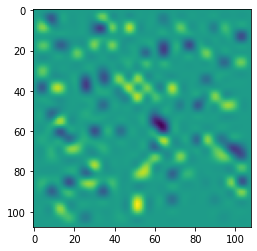

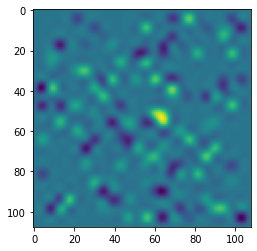

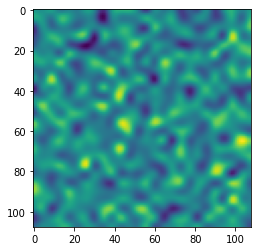

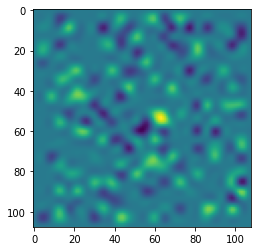

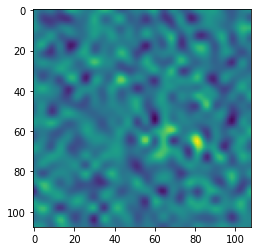

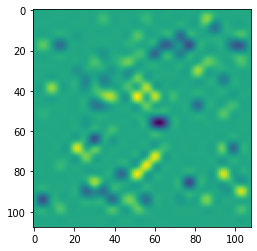

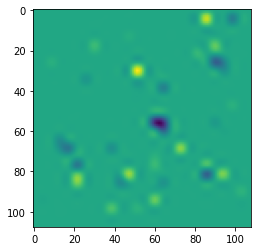

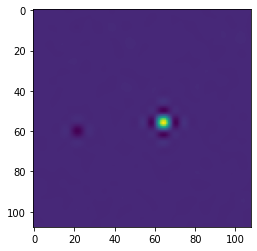

In [28]:
denoised_LSTAs=np.load('/media/eqs8/Samuele_01/Exp_17/analysis/Best_denoised_LSTAS_berens_exp17.npy')
cell=561
ind =np.where(exp_LSTAs_pol_ber[:,0]==cell)[0][0]
print(ind)
for j in range(8):
    plt.figure()
    plt.imshow(denoised_LSTAs[ind,j])
    print(denoised_LSTAs[ind,j].min(),denoised_LSTAs[ind,j].max(),denoised_LSTAs[ind,j].std())

## This cell to count how many LSTAs predicted by the model are ON or OFF

In [5]:
#Choose your modeled experiment with its best run
cells_invs_mouse=[]
cells_invs_salamander=[]
for exp in tqdm([11, 13,17,19, 101,102]):
    if exp==11: results_folder= "/media/samuele/Samuele_01/Exp_11/analysis/cnn_12mixed_tr19/run_019"
    #if exp==12: results_folder= '/media/eqs8/Samuele_01/Exp_12/analysis/cnn_32mixed_tr21/run_060/'
    if exp==13: results_folder= '/media/samuele/Samuele_01/Exp_13/analysis/cnn_9OFF_tr1/run_097/'
    if exp==17: results_folder= '/media/samuele/Samuele_01/Exp_17/analysis/cnn_41mixed_tr28_repeat/run_026'
    if exp==19: results_folder="/media/samuele/Samuele_01/Exp_19/analysis/cnn_28mixed_tr35/run_019"
    if exp==101:results_folder= '/media/samuele/BC_Samuele/20190523_goodone/analyses/cnn_sys_ident/20200616_025316/run_075/'
    if exp==102:results_folder='/media/samuele/Samuele_01/Salamander2/cnn_23mixed_tr34/run_030'

    train_lstas=np.load(os.path.join(results_folder, 'train_lstas.npy'))
    print(train_lstas.shape)

    for cell in range(train_lstas.shape[0]):
        lstas_pol=[]
        for img in train_lstas[cell,:,:,:]:
            if np.abs(img.max())>np.abs(img.min()):
                lstas_pol.append(1)
            else:
                lstas_pol.append(-1)
#         ON=lstas_pol.count(1)
#         OFF=lstas_pol.count(-1)
        lstas_pol=np.array(lstas_pol)
    #     ON=np.count(lstas_pol,1)
    #     OFF=np.count(lstas_pol,-1)
#         print('Cell {0}: {1:.0f}% of LSTAs ON, {2:.0f}% of LSTAs OFF'.format(cell,ON/train_lstas.shape[1]*100,OFF/train_lstas.shape[1]*100))
        if all(lstas_pol==1) or all(lstas_pol==-1):
            if exp>100:cells_invs_salamander.append(0)
            else:cells_invs_mouse.append(0)
        else: 
            if exp>100: cells_invs_salamander.append(1)
            else: cells_invs_mouse.append(1)
cells_invs_mouse=np.array(cells_invs_mouse)
cells_invs_salamander=np.array(cells_invs_salamander)
# print('Number of cells: {0} of which {1} are predicted to have polarity invertion ({2:.3}%) '.format(cells_invs.shape[0], cells_invs.sum(),cells_invs.sum()/cells_invs.shape[0]*100))
print(cells_invs_mouse.sum()/cells_invs_mouse.shape[0]*100, cells_invs_salamander.sum()/cells_invs_salamander.shape[0]*100)

  0%|          | 0/6 [00:00<?, ?it/s]

(12, 2910, 108, 108)


 17%|█▋        | 1/6 [00:14<01:13, 14.76s/it]

(9, 2910, 108, 108)


 33%|███▎      | 2/6 [00:25<00:50, 12.63s/it]

(41, 2910, 108, 108)


 50%|█████     | 3/6 [01:19<01:34, 31.45s/it]

(28, 2910, 108, 108)


 67%|██████▋   | 4/6 [02:03<01:12, 36.25s/it]

(27, 2910, 108, 108)


 83%|████████▎ | 5/6 [03:01<00:44, 44.07s/it]

(23, 2910, 108, 108)


100%|██████████| 6/6 [03:40<00:00, 36.76s/it]

54.44444444444444 66.0


## Assessing wether there is or not a difference in latency for the same neuron when it has ON vs OFF LSTAs

In [76]:
np.sort(np.array(As+Bs))

array([  0,   6,  10,  11,  13,  14,  16,  17,  18,  19,  28,  35,  43,
        44,  46,  49,  54,  56,  58,  60,  63,  72,  83,  92,  95,  96,
       110, 113, 117, 122, 124, 129, 132, 133, 134, 137, 149, 150, 151,
       153, 157, 158, 163, 164, 167, 170, 175, 176, 192, 193, 195, 197,
       200, 201, 202, 209, 216, 224, 225, 227, 233, 234, 235, 236, 237,
       239, 241, 246, 251, 252, 253, 256, 265, 266, 267, 269, 270, 271,
       277, 283, 287, 291, 295, 297, 299, 302, 303, 307, 308, 310, 319,
       322, 328, 329, 334, 337, 339, 341, 348, 351, 356, 357, 360, 366,
       368, 372, 378, 381, 398, 411, 419, 420, 421, 423, 424, 425, 426,
       429, 432, 433, 448, 461, 477, 480, 481, 482, 490, 519, 521, 522,
       523, 541, 542, 544, 554, 557, 570, 575, 593, 601, 616, 627, 628,
       632, 637, 665, 666, 667, 672, 678, 696, 701, 703, 706, 714, 715,
       718, 719, 720, 722, 723, 724, 727, 728])

[260   0  20  20 140 300 160 120]


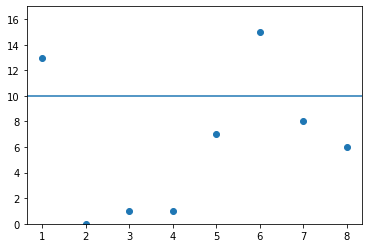

In [56]:
clus=285
raster=np.load('/media/eqs8/Samuele_01/Exp_17/analysis/s1000/exp17_m4_c{0}_s1000_times.pkl'.format(clus),allow_pickle=True)
for i,j in enumerate(raster):
    if i==0:temp=j
    else: temp=np.concatenate((temp,j))
        
nb_bins=int(4800/20 )    #lenght of the stimulus in ms/ lenght of 1 bin in ms
occurrencies, intervals=np.histogram(temp, bins=nb_bins)
lat=[]
for i in range(8):
    lat+= [(occurrencies[np.where((i*0.6+0.03<intervals) & (intervals<i*0.6+0.35))[0]].argmax())]
    
plot(np.arange(8)+1,lat,'o')
axhline(10)
axhline(20)
ylim([0,17])
print(np.array(lat)*20)

In [50]:
exp=17

exp_LSTAs_pol_ber=np.load('/media/eqs8/Samuele_01/Exp_{0}/analysis/exp_LSTAS_labels_berens_exp{0}.npy'.format(exp),allow_pickle=True)
exp_LSTAs_pol_ber

array([[4, array([ 0.,  1.,  1., -1.,  0.,  0.,  0., -1.])],
       [18, array([0., 0., 0., 0., 0., 0., 0., 0.])],
       [19, array([0., 0., 0., 1., 0., 0., 0., 0.])],
       [22, array([-1.,  0., -1., -1.,  0.,  0.,  0., -1.])],
       [30, array([-1.,  0.,  1.,  1.,  0., -1.,  0.,  0.])],
       [53, array([0., 0., 0., 0., 0., 0., 0., 0.])],
       [78, array([-1.,  0.,  0.,  0.,  0., -1.,  0., -1.])],
       [83, array([ 0., -1.,  1.,  0.,  0.,  0.,  0.,  0.])],
       [88, array([0., 0., 0., 0., 0., 0., 0., 0.])],
       [89, array([-1.,  0.,  0.,  0., -1., -1., -1., -1.])],
       [98, array([0., 0., 0., 0., 0., 0., 0., 0.])],
       [113, array([ 0.,  1.,  1.,  1.,  0.,  0.,  1., -1.])],
       [116, array([-1.,  1.,  0., -1.,  0., -1., -1., -1.])],
       [117, array([-1.,  1., -1., -1., -1., -1., -1., -1.])],
       [123, array([0., 0., 0., 0., 0., 0., 0., 0.])],
       [127, array([0., 0., 0., 0., 0., 0., 0., 0.])],
       [130, array([0., 0., 0., 0., 0., 0., 0., 0.])],
     

In [124]:
#try to iterate over inverting cells
exp=17

bin_size=20
nb_imgs=8
latency_diffs=[]
labels=np.load('/media/eqs8/Samuele_01/Exp_{0}/analysis/exp_LSTAS_labels_berens_exp{0}.npy'.format(exp),allow_pickle=True)
for cell in inverting_cells:
    raster=np.load('/media/eqs8/Samuele_01/Exp_17/analysis/s1000/exp17_m4_c{0}_s1000_times.pkl'.format(cell),allow_pickle=True)
    for i,j in enumerate(raster):
        if i==0:temp=j
        else: temp=np.concatenate((temp,j))

    nb_bins=int(nb_imgs*600/bin_size )    #lenght of the raster in ms/ lenght of 1 bin in ms
    occurrencies, intervals=np.histogram(temp, bins=nb_bins)
    lat=[]
    for i in range(nb_imgs):
        lat+= [(occurrencies[np.where((i*0.6+0.03<intervals) & (intervals<i*0.6+0.35))[0]].argmax())]
    lat=np.array(lat)*bin_size
    cell_labels=labels[np.where(labels[:,0]==cell)[0][0]][1]
    bright_lat=[]
    dark_lat=[]
    for img_idx,lab in enumerate(cell_labels):
        if lab==0.: continue
        elif lab== 1.: bright_lat.append(lat[img_idx])
        else: dark_lat.append(lat[img_idx])
    mean_bright_lat= np.array(bright_lat).mean()
    mean_dark_lat= np.array(dark_lat).mean()
    latency_diffs.append(abs(mean_bright_lat-mean_dark_lat))

(array([16.,  6.,  5.,  9.,  5.,  3.,  1.,  0.,  2.,  3.]),
 array([  0. ,  20.5,  41. ,  61.5,  82. , 102.5, 123. , 143.5, 164. ,
        184.5, 205. ]),
 <BarContainer object of 10 artists>)

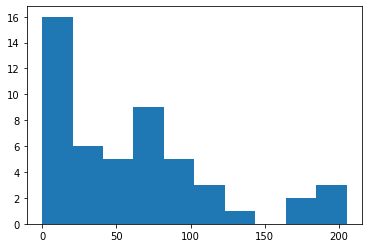

In [129]:
plt.hist(latency_diffs)

In [126]:
len(inverting_cells)

50

In [130]:
latency_diffs

[80.0,
 120.0,
 0.0,
 205.0,
 36.0,
 17.14285714285714,
 50.0,
 170.0,
 72.0,
 196.0,
 63.33333333333334,
 10.0,
 10.0,
 110.0,
 93.33333333333333,
 10.0,
 13.333333333333343,
 14.666666666666657,
 10.0,
 176.0,
 20.0,
 70.0,
 90.0,
 25.0,
 84.0,
 53.33333333333333,
 65.0,
 16.0,
 90.0,
 113.33333333333334,
 60.0,
 20.0,
 64.0,
 100.0,
 136.66666666666669,
 8.0,
 40.0,
 195.0,
 32.0,
 20.0,
 30.0,
 48.0,
 72.0,
 6.666666666666657,
 80.0,
 40.0,
 50.0,
 0.0,
 20.0,
 66.66666666666666]